## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load Training Images

In [240]:
import glob
import os
import sys

def get_img_path_in_folder(path_folder):
    full_path = path_folder + '/**/*.png'
    img_path_list = []

    for filename in glob.iglob(full_path, recursive=True):
        img_path_list.append(filename)

    return img_path_list

data_folder = './data'
vehicles_folder = data_folder + '/vehicles'
non_vehicles_folder = data_folder + '/non-vehicles'

vehicle_img_path = get_img_path_in_folder(vehicles_folder)
non_vehicle_img_path = get_img_path_in_folder(non_vehicles_folder)

print("Vehicles folder", vehicles_folder)
print("Non Vehicle Folder", non_vehicles_folder)

print("Vehicle Images", len(vehicle_img_path))
print("Non Vehicle Images", len(non_vehicle_img_path))

Vehicles folder ./data/vehicles
Non Vehicle Folder ./data/non-vehicles
Vehicle Images 8792
Non Vehicle Images 8968


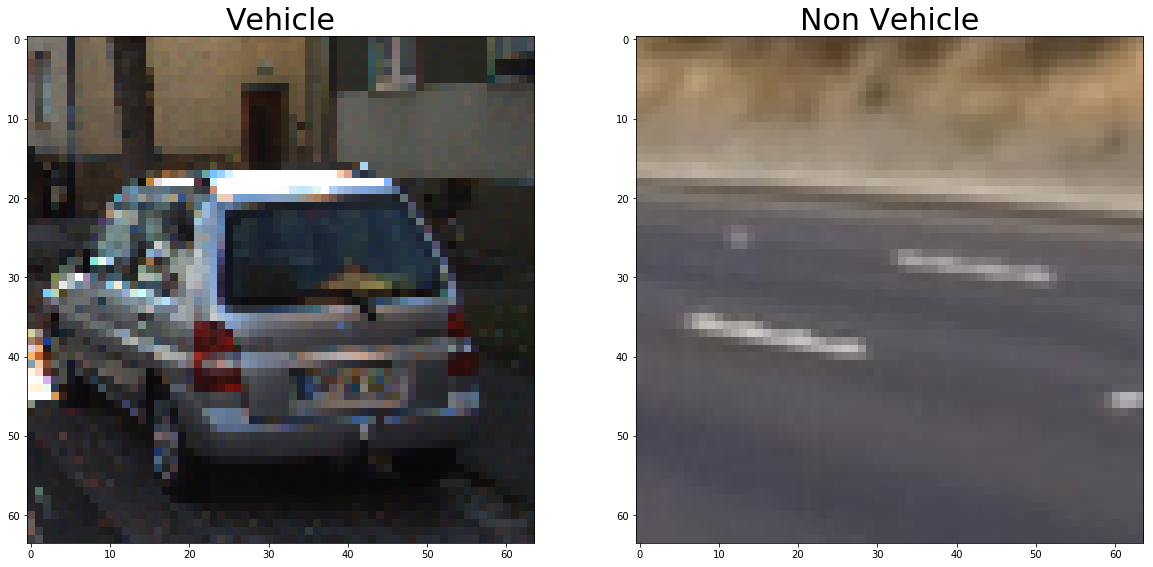

In [245]:
import matplotlib.image as mpimg


def load_random_image(paths):
    len_path = len(paths)
    random_index = np.random.randint(0, len_path)
    return  mpimg.imread(paths[random_index])


vehicle_img = load_random_image(vehicle_img_path)
no_vehicle_img = load_random_image(non_vehicle_img_path)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(no_vehicle_img)
ax2.set_title('Non Vehicle', fontsize=30)


## Extract Features

In [248]:
from skimage.feature import hog
import numpy as np
import cv2

class Feature_Extractor():
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        pass
    
    def extract(self, img):
        
        color_space = self.color_space
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat
        hog_feat = self.hog_feat
        
        #1) Define an empty list to receive features
        img_features = []
        
        #2) Apply color conversion if other than 'RGB'
        feature_image = self.transform_color(img, color_space)
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        
        
        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def transform_color(self, img, color_space='RGB'):
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        return feature_image
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 1)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features

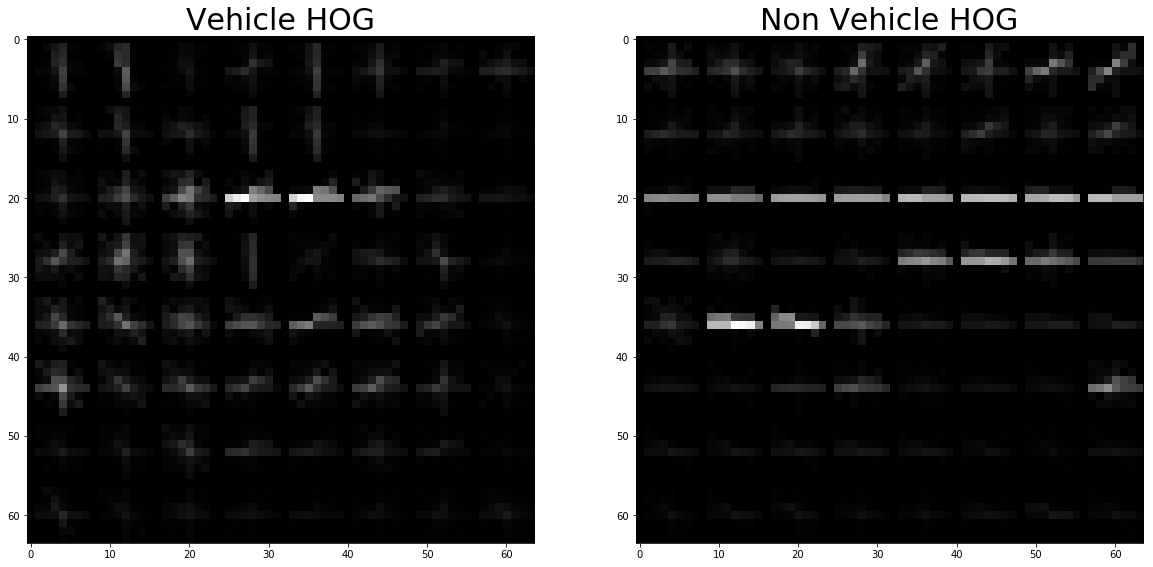

In [271]:
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


extractor = Feature_Extractor(color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


car_hog_feature, car_hog_im = extractor.get_hog_features(vehicle_img[:,:,0], orient =12 , pix_per_cell = 8, cell_per_block = 2, vis=True, feature_vec=False)
non_car_hog_feature, non_car_hog_im = extractor.get_hog_features(no_vehicle_img[:,:,0], orient = 12, pix_per_cell = 8, cell_per_block = 2, vis=True, feature_vec=False)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car_hog_im, cmap='gray')
ax1.set_title('Vehicle HOG', fontsize=30)
ax2.imshow(non_car_hog_im, cmap='gray')
ax2.set_title('Non Vehicle HOG', fontsize=30)

## Training

In [3]:
import numpy as np
from sklearn.utils import shuffle

def images_load_subset(images_path, subset):
    img_len = len(images_path)
    subset = np.clip(subset, 0, 1)
    new_len = img_len*subset
    new_len = int(round(new_len))
    return shuffle(images_path)[:new_len]


def extract_features(img_paths, extrator):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_paths:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature = extractor.extract(image)
        features.append(feature)
    return features

Vehicle Images: 8792 Available: 879
Non Vehicle Images: 8968 Available: 897
Extracting features. Please wait...
21.61 Seconds to extract HOG features...


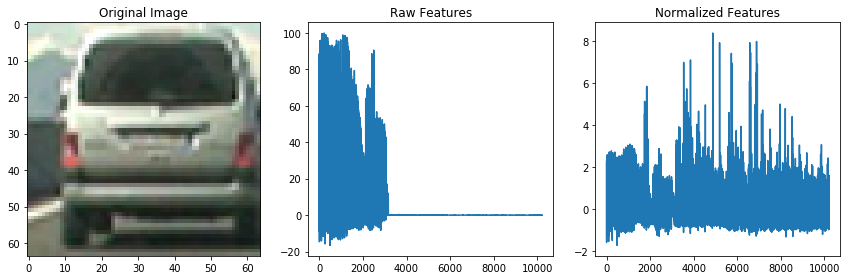

In [302]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler

%matplotlib inline

new_vehicle_images_path = images_load_subset(vehicle_img_path, 0.1)
new_non_vehicle_images_path = images_load_subset(non_vehicle_img_path, 0.1)

old_len = len(vehicle_img_path)
new_len = len(new_vehicle_images_path)
print("Vehicle Images: {0:2d} Available: {1:2d}".format(old_len, new_len))
old_len = len(non_vehicle_img_path)
new_len = len(new_non_vehicle_images_path)
print("Non Vehicle Images: {0:2d} Available: {1:2d}".format(old_len, new_len))

colorspace = 'LUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True # HOG features on or off


extractor = Feature_extractor(color_space=colorspace, spatial_size = spatial_size,
                              hist_bins = hist_bins, orient=orient, 
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel = hog_channel,
                              spatial_feat = True, hist_feat = True, hog_feat = True)

t=time.time()

print('Extracting features. Please wait...')
len_car_images = len(new_vehicle_images_path)
car_features = extract_features(new_vehicle_images_path, extractor)
notcar_features = extract_features(new_non_vehicle_images_path, extractor)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len_car_images)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(new_vehicle_images_path[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Build a Classifier

In [304]:
from sklearn.model_selection import train_test_split

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.980337078652


## Window Creator

In [73]:
import numpy as np
import cv2

class Window_Creator:
    
    def __init__(self, window_size, overlap):
        self.window_size = window_size
        self.overlap = overlap
    
    def get_complex_windows(self, img):
        
        height = img.shape[0]
        y_start = 0.5*height
        y_start = int(round(y_start))
        new_y_start_stop = [y_start, None]
        
        windows_full = []
        windows = []
        
        windows_full, windows = self.get_window_shortcut(img, 50, 0.0, int(round(0.5*height)), int(round(0.7*height)), windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 100, 0.0, int(round(0.5*height)), None, windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 150, 0.2, int(round(0.5*height)), None, windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 200, 0.7, int(round(0.5*height)), None, windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 250, 0.8, int(round(0.5*height)), None, windows_full, windows)

        #aux = self.slide_window(img, xy_window = (200, 200), xy_overlap = (0.8, 0.8), y_start_stop = new_y_start_stop)
        #windows.append(aux)
        #windows_full = self.concatenate(windows_full, aux)
        
        #aux = self.slide_window(img, xy_window = (250, 250), xy_overlap = (0.8, 0.8), y_start_stop = new_y_start_stop)
        #windows.append(aux)
        #windows_full = self.concatenate(windows_full, aux)
        
        
        #overlap = (0.5, 0.5)
        #sizes = []
        #sizes.append((50, 50))
        #sizes.append((100, 100))
        #sizes.append((150, 150))
        #sizes.append((200, 200))
        #sizes.append((250, 250))
        #sizes.append((300, 300))
        #sizes.append((350, 350))
        #sizes.append((400, 400))
        #sizes.append((500, 500))
        
        #windows_full = []
        #windows = []
        #for size in sizes:
            #aux = self.slide_window(img, xy_window = size, xy_overlap = overlap, y_start_stop = new_y_start_stop)
            #windows.append(aux)
            #windows_full = self.concatenate(windows_full, aux)
        
        
        #test_window = ((807, 380),(950, 525))
        #windows.append(test_window)

        return windows_full, windows
        
    def concatenate(self, main_list, new_elements):
        for element in new_elements:
            main_list.append(element)
            
        return main_list
    
    def get_window_shortcut(self, img, size, overlap, y_start, y_stop, windows_full, windows):
        aux = self.slide_window(img, xy_window = (size, size), xy_overlap = (overlap, overlap), y_start_stop = [y_start, y_stop])
        windows.append(aux)
        windows_full = self.concatenate(windows_full, aux)
        return windows_full, windows
    
    def get_windows(self, img):
        windows = self.slide_window(img, xy_window = self.window_size, xy_overlap = self.overlap)
        return windows
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
     
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def draw_windows(self, img):
        windows_full, windows = self.get_complex_windows(img)
        imcopy = np.copy(img)
        thick = 2
        for windows_part in windows:
            r = np.random.randint(0, 255)
            g = np.random.randint(0, 255)
            b = np.random.randint(0, 255)
            imcopy = self.draw_boxes(imcopy, windows_part, color = (r,g,b, 0.5), thick = thick)
            thick +=1
        
        return imcopy
        
    
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=2):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            
            if (color == 'RANDOM'):
                r = np.random.randint(0, 255)
                g = np.random.randint(0, 255)
                b = np.random.randint(0, 255)
                c = (r,g,b)
            else:
                c = color
            cv2.rectangle(imcopy, bbox[0], bbox[1], c, thick)
        # Return the image copy with boxes drawn
        return imcopy


Total Windows:  229


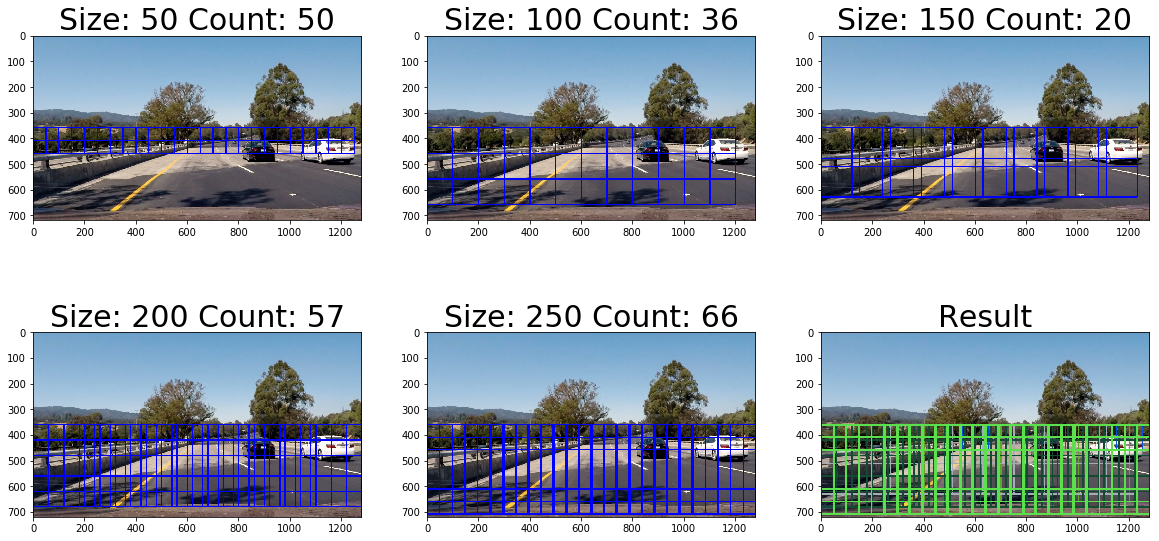

In [90]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

test_img_folder = './test_images/test4.jpg'
test_image = mpimg.imread(test_img_folder)

window_creator = Window_Creator(window_size = (128, 128), overlap = (0.1, 0.1))
image_with_window = window_creator.draw_windows(test_image)
#plt.imshow(image_with_window, interpolation='nearest', aspect='auto')
#mpimg.imsave('./output_images/image_with_windows.png',image_with_window) 

windows_full, windows = window_creator.get_complex_windows(test_image)
print("Total Windows: ", len(windows_full))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.imshow(window_creator.draw_boxes(test_image, windows[0], color = (0,0,255), thick = 4))
num_windows = len(windows[0])
title = "Size: " + str(50) + " Count: " + str(num_windows) 
ax1.set_title(title, fontsize=30)
ax2.imshow(window_creator.draw_boxes(test_image, windows[1], color = (0,0,255), thick = 4))
num_windows = len(windows[1])
title = "Size: " + str(100) + " Count: " + str(num_windows) 
ax2.set_title(title, fontsize=30)
ax3.imshow(window_creator.draw_boxes(test_image, windows[2], color = (0,0,255), thick = 4))
num_windows = len(windows[2])
title = "Size: " + str(150) + " Count: " + str(num_windows) 
ax3.set_title(title, fontsize=30)
ax4.imshow(window_creator.draw_boxes(test_image, windows[3], color = (0,0,255), thick = 4))
num_windows = len(windows[3])
title = "Size: " + str(200) + " Count: " + str(num_windows) 
ax4.set_title(title, fontsize=30)
ax5.imshow(window_creator.draw_boxes(test_image, windows[4], color = (0,0,255), thick = 4))
num_windows = len(windows[4])
title = "Size: " + str(250) + " Count: " + str(num_windows) 
ax5.set_title(title, fontsize=30)
ax6.imshow(image_with_window)
title = 'Result'
ax6.set_title(title, fontsize=30)

## Heatmap

In [211]:
class FixedListQueue():
    def __init__(self, max_size = 3):
        self.count = 0
        self.max_size = max_size
        self.queue = []
        self.full_list = []
        pass
    def enqueue(self, list_to_enqueue):
        if (self.count < self.max_size):
            self.queue.append(list_to_enqueue)
            self.count += 1
        else:
            penultimateIndex = self.count - 2
            for i in range(0, penultimateIndex):
                self.queue[i] = self.queue[i+1]

            lastIndex = self.count -1
            self.queue[lastIndex] = list_to_enqueue
            
        self.full_list = []
        
        for l in self.queue:
            for element in l:
                self.full_list.append(element)
                
        #print("QueueSize", self.count)
                
queue = FixedListQueue()
boxes = []
boxes.append(((1, 2), (3, 4)))
boxes.append(((5, 6), (7, 8)))
queue.enqueue(boxes)
print(queue.full_list)
boxes = []
boxes.append(((10, 20), (30, 40)))
boxes.append(((50, 60), (70, 80)))
queue.enqueue(boxes)
print(queue.full_list)
boxes = []
boxes.append(((100, 200), (300, 400)))
boxes.append(((500, 600), (700, 800)))
queue.enqueue(boxes)
print(queue.full_list)
boxes = []
boxes.append(((1000, 2000), (3000, 4000)))
boxes.append(((5000, 6000), (7000, 8000)))
queue.enqueue(boxes)
print(queue.full_list)

print(queue.queue)
print(queue.full_list)

[((1, 2), (3, 4)), ((5, 6), (7, 8))]
[((1, 2), (3, 4)), ((5, 6), (7, 8)), ((10, 20), (30, 40)), ((50, 60), (70, 80))]
[((1, 2), (3, 4)), ((5, 6), (7, 8)), ((10, 20), (30, 40)), ((50, 60), (70, 80)), ((100, 200), (300, 400)), ((500, 600), (700, 800))]
[((10, 20), (30, 40)), ((50, 60), (70, 80)), ((10, 20), (30, 40)), ((50, 60), (70, 80)), ((1000, 2000), (3000, 4000)), ((5000, 6000), (7000, 8000))]
[[((10, 20), (30, 40)), ((50, 60), (70, 80))], [((10, 20), (30, 40)), ((50, 60), (70, 80))], [((1000, 2000), (3000, 4000)), ((5000, 6000), (7000, 8000))]]
[((10, 20), (30, 40)), ((50, 60), (70, 80)), ((10, 20), (30, 40)), ((50, 60), (70, 80)), ((1000, 2000), (3000, 4000)), ((5000, 6000), (7000, 8000))]


In [218]:
from scipy.ndimage.measurements import label


class HeatMap():
    def __init__(self, size):
        self.size = size
        self.threshold = 1
        self.max_feed = 1
        self.heatmap = np.zeros(self.size).astype(np.float)       
        self.queue = FixedListQueue(self.max_feed)
        pass    

    def feed(self, boxes):
        self.queue.enqueue(boxes)
        cached_boxes = self.queue.full_list
        
        self.heatmap = np.zeros(self.size).astype(np.float)
        self.add_heat(cached_boxes)
        self.apply_threshold(self.threshold)
        self.heatmap_img = self.get_heatmap_img()
        self.labels = heatmap.get_labels(self.heatmap_img)
        self.boxes = heatmap.get_boxes_from_labels(self.labels)

        
        #if (self.feed_count >= self.max_feed):
            #print('Doing')
            #self.apply_threshold(self.threshold)
            #self.heatmap_img = self.get_heatmap_img()
            #self.labels = heatmap.get_labels(self.heatmap_img)
            #self.boxes = heatmap.get_boxes_from_labels(self.labels)
            
            #self.reset()
            


            
    def add_heat(self, boxes):
        #print(self.heatmap.shape)
        # Iterate through list of bboxes
        for box in boxes:
            print(box)
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
    def apply_threshold(self, threshold):
        # Zero out pixels below the threshold
        self.heatmap[self.heatmap <= threshold] = 0
    def get_heatmap_img(self):
        return np.clip(self.heatmap, 0, 255)
    def get_labels(self, heatmap_img):
        return label(heatmap_img)
    def get_boxes_from_labels(self, labels):
        boxes = []
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            boxes.append(bbox)
        # Return the image
        return boxes


((120, 418), (271, 504))
((473, 565), (628, 686))
((800, 400), (900, 500))
((850, 400), (950, 500))
((1050, 400), (1150, 500))
((1100, 400), (1200, 500))
((1150, 400), (1250, 500))
((875, 400), (925, 450))
((1075, 400), (1125, 450))
((825, 425), (875, 475))
((814, 400), (889, 475))
((851, 400), (926, 475))
((1073, 400), (1148, 475))
((1147, 437), (1222, 512))
((1184, 437), (1259, 512))
((400, 400), (500, 500))
((120, 418), (271, 504))
((473, 565), (628, 686))
((800, 400), (900, 500))
((850, 400), (950, 500))
((1050, 400), (1150, 500))
((1100, 400), (1200, 500))
((1150, 400), (1250, 500))
((875, 400), (925, 450))
((1075, 400), (1125, 450))
((825, 425), (875, 475))
((814, 400), (889, 475))
((851, 400), (926, 475))
((1073, 400), (1148, 475))
((1147, 437), (1222, 512))
((1184, 437), (1259, 512))
((400, 400), (500, 500))
((120, 418), (271, 504))
((473, 565), (628, 686))
((800, 400), (900, 500))
((850, 400), (950, 500))
((1050, 400), (1150, 500))
((1100, 400), (1200, 500))
((1150, 400), (125

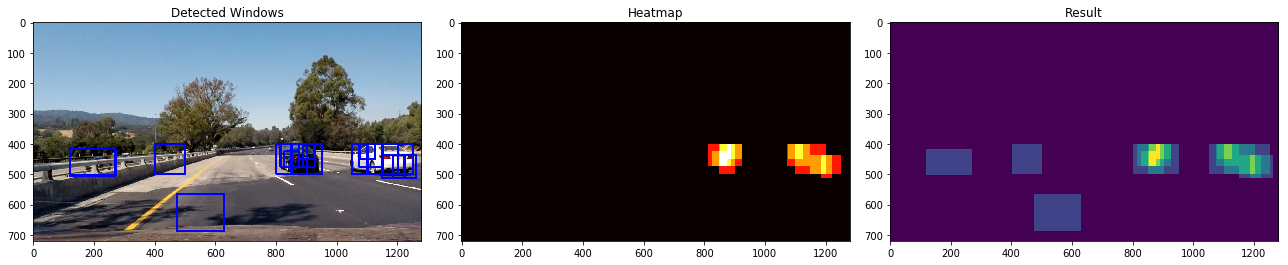

In [219]:
heatmap = HeatMap((720, 1280))

boxes = []
boxes.append(((120, 418), (271, 504)))
boxes.append(((473, 565), (628, 686)))
boxes.append(((800, 400), (900, 500))) 
boxes.append(((850, 400), (950, 500))) 
boxes.append(((1050, 400), (1150, 500))) 
boxes.append(((1100, 400), (1200, 500)))
boxes.append(((1150, 400), (1250, 500))) 
boxes.append(((875, 400), (925, 450))) 
boxes.append(((1075, 400), (1125, 450))) 
boxes.append(((825, 425), (875, 475))) 
boxes.append(((814, 400), (889, 475))) 
boxes.append(((851, 400), (926, 475))) 
boxes.append(((1073, 400), (1148, 475))) 
boxes.append(((1147, 437), (1222, 512)))
boxes.append(((1184, 437), (1259, 512)))
boxes.append(((400, 400), (500, 500)))

heatmap.add_heat(boxes)
heatmap.apply_threshold(1)
heatmap_img = heatmap.get_heatmap_img()
labels = heatmap.get_labels(heatmap_img)

boxes_for_vehicles = heatmap.get_boxes_from_labels(labels)

windows_positive_image = window_creator.draw_boxes(test_image, boxes)
windows_positive_image_with_heat = window_creator.draw_boxes(test_image, boxes_for_vehicles)

heatmap.queue.max_size = 3
heatmap.feed(boxes)
heatmap.feed(boxes)
heatmap.feed(boxes)

windows_positive_image_with_heat2 = window_creator.draw_boxes(test_image, heatmap.boxes)



fig = plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(windows_positive_image)
plt.title('Detected Windows')
plt.subplot(132)
plt.imshow(heatmap_img, cmap='hot')
plt.title('Heatmap')
plt.subplot(133)
plt.imshow(heatmap.heatmap_img)

#plt.imshow(windows_positive_image_with_heat)
plt.title('Result')
fig.tight_layout()
#boxes.append((),())

## Vehicle Detector

In [220]:
class SimpleVehicleClassifier():
    def __init__(self, extractor, classifier, scaler):
        self.extractor = extractor
        self.classifier = classifier
        self.scaler = scaler
    def is_vehicle(self, img):
        features = self.extractor.extract(img)
        test_features = self.scaler.transform(np.array(features).reshape(1, -1))
        prediction = self.classifier.predict(test_features)
        if prediction == 1:
            return True
        else:
            return False

0.819608
[[ 0.17254902  0.2         0.37254903 ...,  0.01176471  0.01568628
   0.01568628]
 [ 0.16470589  0.17254902  0.25490198 ...,  0.00392157  0.00392157
   0.00784314]
 [ 0.15686275  0.16078432  0.16862746 ...,  0.00392157  0.00392157
   0.02352941]
 ..., 
 [ 0.88235295  0.99607843  0.99607843 ...,  0.34901962  0.35294119
   0.35686275]
 [ 0.43137255  0.64313728  0.87450981 ...,  0.34509805  0.34901962
   0.35686275]
 [ 0.42745098  0.41568628  0.41568628 ...,  0.34509805  0.34901962
   0.35294119]]
break
[[ 0.23137255  0.17647059  0.28235295 ...,  0.02745098  0.04313726
   0.05098039]
 [ 0.17647059  0.15294118  0.28235295 ...,  0.01960784  0.02352941
   0.02745098]
 [ 0.16470589  0.16078432  0.1882353  ...,  0.00784314  0.01568628
   0.01960784]
 ..., 
 [ 0.41960785  0.43529412  0.43529412 ...,  0.35294119  0.35686275
   0.36470589]
 [ 0.40000001  0.40784314  0.41568628 ...,  0.35294119  0.36078432
   0.36470589]
 [ 0.36862746  0.38039216  0.3882353  ...,  0.35686275  0.36078432
 

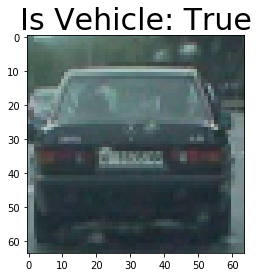

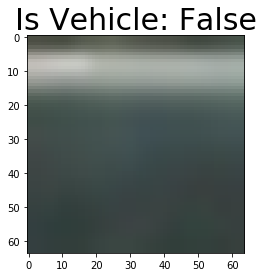

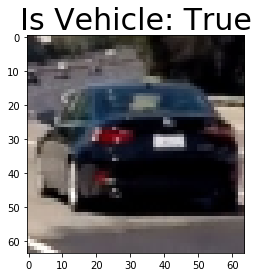

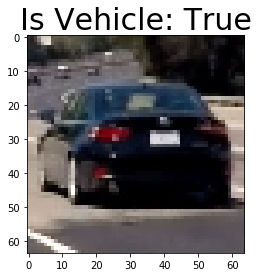

In [221]:
car_ind = np.random.randint(0, len(vehicle_img_path))
non_car_ind = np.random.randint(0, len(non_vehicle_img_path))

vehicle_img = mpimg.imread(vehicle_img_path[car_ind])
non_vehicle_img = mpimg.imread(non_vehicle_img_path[non_car_ind])

simpleClassifier = SimpleVehicleClassifier(extractor, svc, X_scaler)

print(np.amax(vehicle_img))
plt.figure(0)
plt.imshow(vehicle_img)
is_vehicle = simpleClassifier.is_vehicle(vehicle_img)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(1)
plt.imshow(non_vehicle_img)
is_vehicle = simpleClassifier.is_vehicle(non_vehicle_img)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(2)
vehicle_in_window = mpimg.imread('./test_images/vehicle_2.png')
plt.imshow(vehicle_in_window)
is_vehicle = simpleClassifier.is_vehicle(vehicle_in_window)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(3)
crop_image = mpimg.imread('./test_images/test4.jpg')
window = ((807, 380),(950, 525))
crop_image = cv2.resize(crop_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
crop_image = crop_image/255.0
crop_image = crop_image.astype(np.float32)

plt.imshow(crop_image)
is_vehicle = simpleClassifier.is_vehicle(crop_image)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

print(vehicle_in_window[:,:,0])
print("break")
print(crop_image[:,:,0])

In [236]:
class VehicleDetector():
    def __init__(self, simple_detector, window_creator, heatmap):
        self.simple_detector = simple_detector
        self.window_creator = window_creator
        self.heatmap = heatmap
    
    def configure(self, threshold_frame, threshold_heat):
        self.heatmap.max_feed = threshold_frame
        self.heatmap.queue.max_size = threshold_frame
        self.heatmap.threshold = threshold_heat
        self.heatmap.boxes = []
        self.heatmap.queue.max_size = threshold_frame
        self.heatmap.queue.count = 0
        self.heatmap.queue.queue = []
        self.heatmap.queue.full_list = []      
        
        
    def detect(self, img):
        windows = self.get_windows(img)
        max_value = np.amax(img)
        if (max_value > 1):
            img = img /255
            img = img.astype(np.float32)
        
        #print(np.amax(img))
        windows_with_vehicle = []
        count = 0
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            #print(np.amax(test_img))
            #plt.figure(count)
            #plt.imshow(test_img)
            count = count + 1
            is_vehicle = self.simple_detector.is_vehicle(test_img)
            if (is_vehicle == True):
                #print("Found!")
                windows_with_vehicle.append(window)
        #print(count)
        self.heatmap.feed(windows_with_vehicle)

        #print(len(heatmap_vehicles))
        #print(heatmap_vehicles[0])
        
        heatmap_img = self.heatmap.heatmap_img
        heat_max = np.amax(heatmap_img)
        print(heatmap_img)
        print(heat_max)
        heatmap_img = (heatmap_img/heat_max)*255
        heatmap_rgb = np.dstack((np.zeros_like(heatmap_img), np.zeros_like(heatmap_img), heatmap_img))

        #return heatmap_rgb
        full_list = self.heatmap.queue.full_list
        heatmap_vehicles = self.heatmap.boxes
        aux = self.window_creator.draw_boxes(img*255, windows_with_vehicle, color=(0, 0, 255), thick=1)
        aux = self.window_creator.draw_boxes(aux, full_list, color=(0, 255, 0), thick=1)

        return self.window_creator.draw_boxes(aux, heatmap_vehicles, color=(255, 0, 0), thick=6)

    
    def get_windows(self, img):
        windows = []
        windows = self.window_creator.get_complex_windows(img)
        return windows

                
        

((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.0
((825, 363), (975, 513))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
2.0
((825, 363), (975, 513))
((825, 363), (975, 513))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
3.0


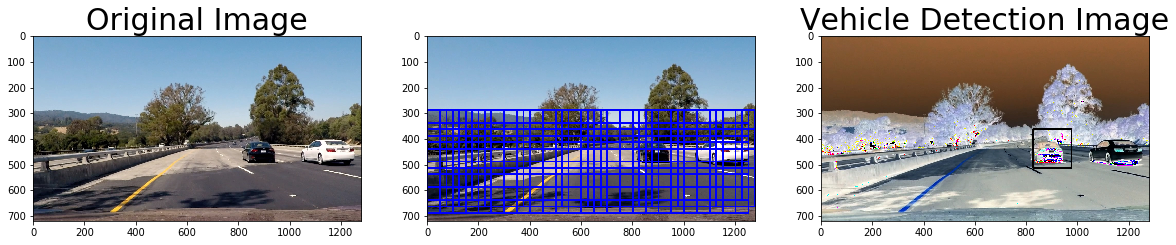

In [237]:
test_image_path = './test_images/test4.jpg'
test_image = mpimg.imread(test_image_path)
window_creator.overlap = (0.1, 0.1)
window_creator.window_size = (200, 200)

vehicle_detector = VehicleDetector(simpleClassifier, window_creator, heatmap)
vehicle_detector.configure(threshold_frame = 6, threshold_heat = 1)


result = vehicle_detector.detect(test_image)
result = vehicle_detector.detect(test_image)
result = vehicle_detector.detect(test_image)

image_with_window = window_creator.draw_windows(test_image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_with_window)
ax3.set_title('Windows', fontsize=30)
ax3.imshow(result)
ax3.set_title('Vehicle Detection Image', fontsize=30)

## Video Pipeline

In [239]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_detector = VehicleDetector(simpleClassifier, window_creator, heatmap)
vehicle_detector.configure(threshold_frame = 6, threshold_heat = 3)

video_output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video_shortest.mp4")
#clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("project_video.mp4")


#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = clip1.fl_image(vehicle_detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

((300, 338), (400, 438))
((700, 338), (800, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.0
[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  0%|                                                                                                                                                     | 0/1261 [00:00<?, ?it/s]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((700, 338), (800, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.0


  0%|                                                                                                                                             | 1/1261 [00:01<34:36,  1.65s/it]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.0


  0%|▏                                                                                                                                            | 2/1261 [00:03<37:19,  1.78s/it]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((500, 413), (750, 663))
((300, 338), (400, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
4.0


  0%|▎                                                                                                                                            | 3/1261 [00:05<37:26,  1.79s/it]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((500, 413), (750, 663))
((300, 338), (400, 438))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  0%|▍                                                                                                                                            | 4/1261 [00:07<36:28,  1.74s/it]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((500, 413), (750, 663))
((300, 338), (400, 438))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  0%|▌                                                                                                                                            | 5/1261 [00:08<36:30,  1.74s/it]

((300, 338), (400, 438))
((700, 338), (800, 438))
((300, 338), (400, 438))
((500, 413), (750, 663))
((300, 338), (400, 438))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((600, 538), (700, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  0%|▋                                                                                                                                            | 6/1261 [00:10<36:07,  1.73s/it]

((300, 338), (400, 438))
((500, 413), (750, 663))
((300, 338), (400, 438))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 338), (850, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  1%|▊                                                                                                                                            | 7/1261 [00:12<35:40,  1.71s/it]

((300, 338), (400, 438))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 338), (850, 438))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  1%|▉                                                                                                                                            | 8/1261 [00:13<35:27,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 338), (850, 438))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  1%|█                                                                                                                                            | 9/1261 [00:15<35:15,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((750, 338), (850, 438))
((800, 388), (900, 488))
((550, 438), (650, 538))
((700, 488), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  1%|█                                                                                                                                           | 10/1261 [00:17<35:03,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 338), (850, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  1%|█▏                                                                                                                                          | 11/1261 [00:18<34:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 338), (850, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  1%|█▎                                                                                                                                          | 12/1261 [00:20<35:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 488), (800, 588))
((200, 588), (300, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  1%|█▍                                                                                                                                          | 13/1261 [00:22<35:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((200, 588), (300, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  1%|█▌                                                                                                                                          | 14/1261 [00:24<35:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


  1%|█▋                                                                                                                                          | 15/1261 [00:25<34:51,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((550, 438), (650, 538))
((900, 438), (1050, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  1%|█▊                                                                                                                                          | 16/1261 [00:27<34:58,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  1%|█▉                                                                                                                                          | 17/1261 [00:29<34:55,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  1%|█▉                                                                                                                                          | 18/1261 [00:30<34:33,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██                                                                                                                                          | 19/1261 [00:32<34:22,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 588), (850, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▏                                                                                                                                         | 20/1261 [00:34<34:37,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 488), (650, 588))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  2%|██▎                                                                                                                                         | 21/1261 [00:35<34:16,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 288), (975, 438))
((250, 288), (500, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▍                                                                                                                                         | 22/1261 [00:37<34:06,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 288), (975, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  2%|██▌                                                                                                                                         | 23/1261 [00:39<34:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((550, 438), (650, 538))
((825, 288), (975, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▋                                                                                                                                         | 24/1261 [00:40<34:17,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((825, 288), (975, 438))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▊                                                                                                                                         | 25/1261 [00:42<34:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((825, 288), (975, 438))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▉                                                                                                                                         | 26/1261 [00:44<35:23,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((900, 288), (1000, 388))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|██▉                                                                                                                                         | 27/1261 [00:46<39:14,  1.91s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((900, 288), (1050, 438))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|███                                                                                                                                         | 28/1261 [00:48<38:21,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((400, 588), (500, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  2%|███▏                                                                                                                                        | 29/1261 [00:50<37:40,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((400, 588), (500, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  2%|███▎                                                                                                                                        | 30/1261 [00:52<38:41,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  2%|███▍                                                                                                                                        | 31/1261 [00:54<40:21,  1.97s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((950, 288), (1050, 388))
((900, 288), (1050, 438))
((800, 288), (1000, 488))
((250, 288), (500, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  3%|███▌                                                                                                                                        | 32/1261 [00:55<38:47,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((900, 288), (1050, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|███▋                                                                                                                                        | 33/1261 [00:57<38:20,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((950, 288), (1050, 388))
((550, 438), (650, 538))
((900, 488), (1000, 588))
((525, 438), (675, 588))
((800, 288), (1000, 488))
((900, 488), (1100, 688))
((250, 288), (500, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  3%|███▊                                                                                                                                        | 34/1261 [00:59<37:50,  1.85s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((550, 438), (650, 538))
((800, 288), (1000, 488))
((250, 288), (500, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  3%|███▉                                                                                                                                        | 35/1261 [01:01<37:05,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((900, 288), (1050, 438))
((975, 288), (1125, 438))
((800, 288), (1000, 488))
((250, 288), (500, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  3%|███▉                                                                                                                                        | 36/1261 [01:03<37:18,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((1000, 288), (1100, 388))
((825, 288), (975, 438))
((800, 288), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████                                                                                                                                        | 37/1261 [01:04<37:05,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((1000, 288), (1100, 388))
((550, 338), (650, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  3%|████▏                                                                                                                                       | 38/1261 [01:06<36:25,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((550, 338), (650, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  3%|████▎                                                                                                                                       | 39/1261 [01:08<36:14,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((975, 288), (1125, 438))
((800, 288), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████▍                                                                                                                                       | 40/1261 [01:10<35:38,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((800, 288), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████▌                                                                                                                                       | 41/1261 [01:11<35:53,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1050, 438))
((975, 288), (1125, 438))
((800, 288), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████▋                                                                                                                                       | 42/1261 [01:13<35:39,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████▊                                                                                                                                       | 43/1261 [01:15<35:44,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((200, 588), (300, 688))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  3%|████▉                                                                                                                                       | 44/1261 [01:17<36:29,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((250, 588), (350, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  4%|████▉                                                                                                                                       | 45/1261 [01:19<36:15,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((900, 288), (1050, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  4%|█████                                                                                                                                       | 46/1261 [01:20<36:11,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((950, 288), (1050, 388))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((550, 438), (650, 538))
((850, 438), (950, 538))
((900, 488), (1000, 588))
((900, 288), (1050, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  4%|█████▏                                                                                                                                      | 47/1261 [01:22<35:20,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((900, 288), (1050, 438))
((200, 288), (400, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  4%|█████▎                                                                                                                                      | 48/1261 [01:24<34:38,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((150, 588), (250, 688))
((200, 588), (300, 688))
((900, 288), (1050, 438))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  4%|█████▍                                                                                                                                      | 49/1261 [01:25<34:19,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((1100, 288), (1200, 388))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  4%|█████▌                                                                                                                                      | 50/1261 [01:27<33:59,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((800, 388), (900, 488))
((50, 488), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  4%|█████▋                                                                                                                                      | 51/1261 [01:29<34:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((800, 388), (900, 488))
((50, 488), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  4%|█████▊                                                                                                                                      | 52/1261 [01:30<33:41,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1100, 288), (1200, 388))
((1100, 438), (1200, 538))
((250, 588), (350, 688))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  4%|█████▉                                                                                                                                      | 53/1261 [01:32<33:31,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((1100, 288), (1200, 388))
((550, 438), (650, 538))
((1150, 438), (1250, 538))
((975, 288), (1125, 438))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  4%|█████▉                                                                                                                                      | 54/1261 [01:34<34:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((1100, 288), (1200, 388))
((550, 338), (650, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  4%|██████                                                                                                                                      | 55/1261 [01:35<33:58,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1050, 288), (1150, 388))
((1100, 288), (1200, 388))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  4%|██████▏                                                                                                                                     | 56/1261 [01:37<34:00,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|██████▎                                                                                                                                     | 57/1261 [01:39<33:57,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
((1150, 288), (1250, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|██████▍                                                                                                                                     | 58/1261 [01:40<34:00,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
((1150, 288), (1250, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|██████▌                                                                                                                                     | 59/1261 [01:42<34:14,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|██████▋                                                                                                                                     | 60/1261 [01:44<34:10,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  5%|██████▊                                                                                                                                     | 61/1261 [01:46<34:05,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  5%|██████▉                                                                                                                                     | 62/1261 [01:47<33:53,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 338), (900, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|██████▉                                                                                                                                     | 63/1261 [01:49<33:53,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|███████                                                                                                                                     | 64/1261 [01:51<33:42,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|███████▏                                                                                                                                    | 65/1261 [01:52<33:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|███████▎                                                                                                                                    | 66/1261 [01:54<33:29,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  5%|███████▍                                                                                                                                    | 67/1261 [01:56<33:11,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|███████▌                                                                                                                                    | 68/1261 [01:57<33:19,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  5%|███████▋                                                                                                                                    | 69/1261 [01:59<33:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((1050, 513), (1200, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|███████▊                                                                                                                                    | 70/1261 [02:01<33:12,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  6%|███████▉                                                                                                                                    | 71/1261 [02:02<32:57,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  6%|███████▉                                                                                                                                    | 72/1261 [02:04<33:00,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████                                                                                                                                    | 73/1261 [02:06<33:00,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████▏                                                                                                                                   | 74/1261 [02:07<33:08,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((300, 388), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████▎                                                                                                                                   | 75/1261 [02:09<32:56,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((300, 388), (400, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████▍                                                                                                                                   | 76/1261 [02:11<32:51,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 388), (400, 488))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  6%|████████▌                                                                                                                                   | 77/1261 [02:12<32:54,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((900, 438), (1000, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  6%|████████▋                                                                                                                                   | 78/1261 [02:14<33:05,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████▊                                                                                                                                   | 79/1261 [02:16<33:03,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((300, 338), (400, 438))
((1000, 538), (1100, 638))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  6%|████████▉                                                                                                                                   | 80/1261 [02:17<33:07,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  6%|████████▉                                                                                                                                   | 81/1261 [02:19<33:05,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  7%|█████████                                                                                                                                   | 82/1261 [02:21<33:00,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  7%|█████████▏                                                                                                                                  | 83/1261 [02:23<33:09,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  7%|█████████▎                                                                                                                                  | 84/1261 [02:24<32:59,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  7%|█████████▍                                                                                                                                  | 85/1261 [02:26<32:51,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  7%|█████████▌                                                                                                                                  | 86/1261 [02:28<32:53,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  7%|█████████▋                                                                                                                                  | 87/1261 [02:29<32:36,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  7%|█████████▊                                                                                                                                  | 88/1261 [02:31<32:48,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((550, 438), (650, 538))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


  7%|█████████▉                                                                                                                                  | 89/1261 [02:33<32:46,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((700, 338), (800, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  7%|█████████▉                                                                                                                                  | 90/1261 [02:34<32:48,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  7%|██████████                                                                                                                                  | 91/1261 [02:36<32:51,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((900, 488), (1000, 588))
((900, 288), (1050, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  7%|██████████▏                                                                                                                                 | 92/1261 [02:38<32:47,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  7%|██████████▎                                                                                                                                 | 93/1261 [02:39<32:28,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  7%|██████████▍                                                                                                                                 | 94/1261 [02:41<32:28,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  8%|██████████▌                                                                                                                                 | 95/1261 [02:43<33:32,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  8%|██████████▋                                                                                                                                 | 96/1261 [02:45<36:30,  1.88s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|██████████▊                                                                                                                                 | 97/1261 [02:47<35:59,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  8%|██████████▉                                                                                                                                 | 98/1261 [02:48<34:52,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|██████████▉                                                                                                                                 | 99/1261 [02:50<34:33,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((750, 338), (850, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|███████████                                                                                                                                | 100/1261 [02:52<34:02,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((750, 338), (850, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|███████████▏                                                                                                                               | 101/1261 [02:54<33:33,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  8%|███████████▏                                                                                                                               | 102/1261 [02:55<32:53,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  8%|███████████▎                                                                                                                               | 103/1261 [02:57<32:39,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


  8%|███████████▍                                                                                                                               | 104/1261 [02:59<32:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|███████████▌                                                                                                                               | 105/1261 [03:00<32:17,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((1100, 438), (1200, 538))
((100, 488), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  8%|███████████▋                                                                                                                               | 106/1261 [03:02<32:25,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 438), (1000, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  8%|███████████▊                                                                                                                               | 107/1261 [03:04<32:30,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|███████████▉                                                                                                                               | 108/1261 [03:05<32:17,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((350, 338), (450, 438))
((0, 488), (100, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|████████████                                                                                                                               | 109/1261 [03:07<32:02,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((350, 338), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|████████████▏                                                                                                                              | 110/1261 [03:09<32:03,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((350, 338), (450, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|████████████▏                                                                                                                              | 111/1261 [03:10<31:55,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|████████████▎                                                                                                                              | 112/1261 [03:12<31:42,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  9%|████████████▍                                                                                                                              | 113/1261 [03:14<32:02,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|████████████▌                                                                                                                              | 114/1261 [03:15<31:50,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  9%|████████████▋                                                                                                                              | 115/1261 [03:17<32:11,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  9%|████████████▊                                                                                                                              | 116/1261 [03:19<32:02,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


  9%|████████████▉                                                                                                                              | 117/1261 [03:20<32:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|█████████████                                                                                                                              | 118/1261 [03:22<32:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((600, 338), (700, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((900, 588), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


  9%|█████████████                                                                                                                              | 119/1261 [03:24<31:55,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((600, 338), (700, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 10%|█████████████▏                                                                                                                             | 120/1261 [03:25<31:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((200, 588), (300, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 10%|█████████████▎                                                                                                                             | 121/1261 [03:27<31:57,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|█████████████▍                                                                                                                             | 122/1261 [03:29<31:43,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 10%|█████████████▌                                                                                                                             | 123/1261 [03:30<31:38,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|█████████████▋                                                                                                                             | 124/1261 [03:32<31:17,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 10%|█████████████▊                                                                                                                             | 125/1261 [03:34<31:27,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((550, 338), (650, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|█████████████▉                                                                                                                             | 126/1261 [03:35<31:21,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|█████████████▉                                                                                                                             | 127/1261 [03:37<31:14,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|██████████████                                                                                                                             | 128/1261 [03:39<31:29,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((900, 588), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 10%|██████████████▏                                                                                                                            | 129/1261 [03:40<31:45,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|██████████████▎                                                                                                                            | 130/1261 [03:42<31:33,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1200, 438))
((800, 288), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|██████████████▍                                                                                                                            | 131/1261 [03:44<31:34,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 10%|██████████████▌                                                                                                                            | 132/1261 [03:45<31:12,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|██████████████▋                                                                                                                            | 133/1261 [03:47<31:07,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 388), (200, 488))
((200, 588), (300, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|██████████████▊                                                                                                                            | 134/1261 [03:49<31:11,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|██████████████▉                                                                                                                            | 135/1261 [03:50<31:22,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 388), (150, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|██████████████▉                                                                                                                            | 136/1261 [03:52<31:28,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|███████████████                                                                                                                            | 137/1261 [03:54<31:25,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|███████████████▏                                                                                                                           | 138/1261 [03:55<31:22,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|███████████████▎                                                                                                                           | 139/1261 [03:57<31:30,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|███████████████▍                                                                                                                           | 140/1261 [03:59<31:28,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((1100, 438), (1200, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|███████████████▌                                                                                                                           | 141/1261 [04:01<31:41,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|███████████████▋                                                                                                                           | 142/1261 [04:02<31:35,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((1100, 438), (1200, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|███████████████▊                                                                                                                           | 143/1261 [04:04<31:19,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((650, 338), (750, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 11%|███████████████▊                                                                                                                           | 144/1261 [04:06<31:06,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 11%|███████████████▉                                                                                                                           | 145/1261 [04:07<31:09,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 288), (1050, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|████████████████                                                                                                                           | 146/1261 [04:09<31:15,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 288), (1050, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|████████████████▏                                                                                                                          | 147/1261 [04:11<31:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 288), (1050, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 12%|████████████████▎                                                                                                                          | 148/1261 [04:12<31:28,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((150, 488), (250, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 12%|████████████████▍                                                                                                                          | 149/1261 [04:14<31:28,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((650, 338), (750, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 12%|████████████████▌                                                                                                                          | 150/1261 [04:16<31:23,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 12%|████████████████▋                                                                                                                          | 151/1261 [04:17<31:28,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((650, 438), (750, 538))
((0, 488), (100, 588))
((50, 488), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|████████████████▊                                                                                                                          | 152/1261 [04:19<31:34,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 12%|████████████████▊                                                                                                                          | 153/1261 [04:21<31:29,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|████████████████▉                                                                                                                          | 154/1261 [04:23<31:22,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((400, 388), (500, 488))
((900, 588), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|█████████████████                                                                                                                          | 155/1261 [04:24<31:28,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 288), (900, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 12%|█████████████████▏                                                                                                                         | 156/1261 [04:26<31:04,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 488), (600, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 12%|█████████████████▎                                                                                                                         | 157/1261 [04:28<30:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((750, 288), (900, 438))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▍                                                                                                                         | 158/1261 [04:29<31:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▌                                                                                                                         | 159/1261 [04:31<30:42,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▋                                                                                                                         | 160/1261 [04:33<30:41,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▋                                                                                                                         | 161/1261 [04:34<30:39,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▊                                                                                                                         | 162/1261 [04:36<30:42,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((750, 488), (850, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|█████████████████▉                                                                                                                         | 163/1261 [04:38<30:35,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|██████████████████                                                                                                                         | 164/1261 [04:39<30:24,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 488), (1250, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 13%|██████████████████▏                                                                                                                        | 165/1261 [04:41<30:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 13%|██████████████████▎                                                                                                                        | 166/1261 [04:43<31:14,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 438), (1250, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 13%|██████████████████▍                                                                                                                        | 167/1261 [04:45<34:14,  1.88s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((400, 588), (500, 688))
((975, 288), (1125, 438))
((1125, 363), (1275, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 13%|██████████████████▌                                                                                                                        | 168/1261 [04:47<33:20,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((600, 338), (700, 438))
((1150, 388), (1250, 488))
((975, 288), (1125, 438))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 13%|██████████████████▋                                                                                                                        | 169/1261 [04:48<32:21,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1150, 388), (1250, 488))
((500, 538), (600, 638))
((975, 288), (1125, 438))
((1125, 363), (1275, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 13%|██████████████████▋                                                                                                                        | 170/1261 [04:50<31:56,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 338), (800, 438))
((1150, 388), (1250, 488))
((975, 288), (1125, 438))
((1125, 363), (1275, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 14%|██████████████████▊                                                                                                                        | 171/1261 [04:52<31:23,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((700, 338), (800, 438))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|██████████████████▉                                                                                                                        | 172/1261 [04:53<31:13,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((700, 338), (800, 438))
((700, 488), (800, 588))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████                                                                                                                        | 173/1261 [04:55<31:09,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((700, 338), (800, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████▏                                                                                                                       | 174/1261 [04:57<30:58,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((700, 338), (800, 438))
((550, 438), (650, 538))
((400, 588), (500, 688))
((750, 288), (900, 438))
((400, 488), (600, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 14%|███████████████████▎                                                                                                                       | 175/1261 [04:59<30:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((400, 588), (500, 688))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████▍                                                                                                                       | 176/1261 [05:00<30:34,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 588), (200, 688))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████▌                                                                                                                       | 177/1261 [05:02<30:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 588), (600, 688))
((400, 488), (600, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 14%|███████████████████▌                                                                                                                       | 178/1261 [05:04<30:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 388), (1250, 488))
((1150, 438), (1250, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████▋                                                                                                                       | 179/1261 [05:05<31:00,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|███████████████████▊                                                                                                                       | 180/1261 [05:07<31:08,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 14%|███████████████████▉                                                                                                                       | 181/1261 [05:09<30:52,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 14%|████████████████████                                                                                                                       | 182/1261 [05:10<30:35,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (200, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▏                                                                                                                      | 183/1261 [05:12<30:27,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▎                                                                                                                      | 184/1261 [05:14<30:25,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 388), (500, 488))
((550, 438), (650, 538))
((150, 588), (250, 688))
((400, 588), (500, 688))
((375, 363), (525, 513))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▍                                                                                                                      | 185/1261 [05:15<30:10,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((1050, 288), (1200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▌                                                                                                                      | 186/1261 [05:17<30:11,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((600, 538), (700, 638))
((1050, 288), (1200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▌                                                                                                                      | 187/1261 [05:19<30:13,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((350, 338), (450, 438))
((550, 438), (650, 538))
((1050, 288), (1200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▋                                                                                                                      | 188/1261 [05:21<30:41,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((550, 438), (650, 538))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|████████████████████▊                                                                                                                      | 189/1261 [05:22<30:41,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
((550, 438), (650, 538))
((100, 588), (200, 688))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 15%|████████████████████▉                                                                                                                      | 190/1261 [05:24<30:34,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((100, 588), (200, 688))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 15%|█████████████████████                                                                                                                      | 191/1261 [05:26<30:23,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((400, 588), (500, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|█████████████████████▏                                                                                                                     | 192/1261 [05:27<30:21,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((1100, 388), (1200, 488))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|█████████████████████▎                                                                                                                     | 193/1261 [05:29<30:25,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((1150, 288), (1250, 388))
((600, 488), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 15%|█████████████████████▍                                                                                                                     | 194/1261 [05:31<30:10,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 15%|█████████████████████▍                                                                                                                     | 195/1261 [05:33<30:11,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((400, 588), (500, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|█████████████████████▌                                                                                                                     | 196/1261 [05:34<29:57,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((500, 488), (700, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|█████████████████████▋                                                                                                                     | 197/1261 [05:36<29:45,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((650, 338), (750, 438))
((1100, 388), (1200, 488))
((400, 588), (500, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|█████████████████████▊                                                                                                                     | 198/1261 [05:38<29:56,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((950, 288), (1050, 388))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 16%|█████████████████████▉                                                                                                                     | 199/1261 [05:39<30:02,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((500, 538), (600, 638))
((100, 588), (200, 688))
((400, 588), (500, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|██████████████████████                                                                                                                     | 200/1261 [05:41<29:48,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 288), (1050, 388))
((1100, 388), (1200, 488))
((400, 588), (500, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 16%|██████████████████████▏                                                                                                                    | 201/1261 [05:43<30:00,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((1100, 438), (1200, 538))
((400, 588), (500, 688))
((500, 588), (600, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 16%|██████████████████████▎                                                                                                                    | 202/1261 [05:44<29:43,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((1100, 438), (1200, 538))
((400, 588), (500, 688))
((500, 588), (600, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 16%|██████████████████████▍                                                                                                                    | 203/1261 [05:46<29:53,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((400, 588), (500, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 16%|██████████████████████▍                                                                                                                    | 204/1261 [05:48<29:48,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((1100, 438), (1200, 538))
((1050, 513), (1200, 663))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|██████████████████████▌                                                                                                                    | 205/1261 [05:50<30:08,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((450, 338), (550, 438))
((200, 588), (300, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|██████████████████████▋                                                                                                                    | 206/1261 [05:51<29:53,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((1000, 288), (1100, 388))
((400, 588), (500, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 16%|██████████████████████▊                                                                                                                    | 207/1261 [05:53<29:57,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((950, 288), (1050, 388))
((1000, 288), (1100, 388))
((450, 338), (550, 438))
((250, 588), (350, 688))
((400, 588), (500, 688))
((600, 288), (800, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 16%|██████████████████████▉                                                                                                                    | 208/1261 [05:55<29:47,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((400, 338), (500, 438))
((450, 338), (550, 438))
((250, 588), (350, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 17%|███████████████████████                                                                                                                    | 209/1261 [05:56<30:07,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((400, 338), (500, 438))
((450, 338), (550, 438))
((1100, 388), (1200, 488))
((550, 438), (650, 538))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 17%|███████████████████████▏                                                                                                                   | 210/1261 [05:58<30:00,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((200, 588), (300, 688))
((400, 488), (600, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 17%|███████████████████████▎                                                                                                                   | 211/1261 [06:00<29:45,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((200, 588), (300, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 17%|███████████████████████▎                                                                                                                   | 212/1261 [06:01<29:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((750, 488), (850, 588))
((200, 588), (300, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 17%|███████████████████████▍                                                                                                                   | 213/1261 [06:03<29:37,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 17%|███████████████████████▌                                                                                                                   | 214/1261 [06:05<30:40,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 388), (500, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 17%|███████████████████████▋                                                                                                                   | 215/1261 [06:07<31:19,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 588), (500, 688))
((1050, 363), (1200, 513))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 17%|███████████████████████▊                                                                                                                   | 216/1261 [06:09<32:21,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 338), (950, 438))
((400, 388), (500, 488))
((400, 588), (500, 688))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 17%|███████████████████████▉                                                                                                                   | 217/1261 [06:11<32:22,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 338), (950, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 17%|████████████████████████                                                                                                                   | 218/1261 [06:13<32:34,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 17%|████████████████████████▏                                                                                                                  | 219/1261 [06:14<32:14,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
((1050, 363), (1200, 513))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 17%|████████████████████████▎                                                                                                                  | 220/1261 [06:16<31:45,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((550, 588), (650, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 18%|████████████████████████▎                                                                                                                  | 221/1261 [06:18<32:18,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((375, 288), (525, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|████████████████████████▍                                                                                                                  | 222/1261 [06:20<32:36,  1.88s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((375, 288), (525, 438))
((500, 488), (700, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 18%|████████████████████████▌                                                                                                                  | 223/1261 [06:22<32:25,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((375, 288), (525, 438))
((825, 288), (975, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|████████████████████████▋                                                                                                                  | 224/1261 [06:24<32:09,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((375, 288), (525, 438))
((1125, 363), (1275, 513))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 18%|████████████████████████▊                                                                                                                  | 225/1261 [06:26<32:02,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 538), (650, 638))
((375, 288), (525, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|████████████████████████▉                                                                                                                  | 226/1261 [06:28<32:06,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 388), (250, 488))
((400, 588), (500, 688))
((375, 288), (525, 438))
((1050, 363), (1200, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████                                                                                                                  | 227/1261 [06:29<32:20,  1.88s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((375, 288), (525, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████▏                                                                                                                 | 228/1261 [06:31<32:08,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 338), (1000, 438))
((550, 538), (650, 638))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████▏                                                                                                                 | 229/1261 [06:33<31:57,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 338), (1000, 438))
((375, 288), (525, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████▎                                                                                                                 | 230/1261 [06:35<31:20,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████▍                                                                                                                 | 231/1261 [06:37<30:26,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 18%|█████████████████████████▌                                                                                                                 | 232/1261 [06:38<29:49,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((650, 538), (750, 638))
((375, 288), (525, 438))
((700, 288), (900, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 18%|█████████████████████████▋                                                                                                                 | 233/1261 [06:40<29:20,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((375, 288), (525, 438))
((700, 288), (900, 488))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|█████████████████████████▊                                                                                                                 | 234/1261 [06:42<29:25,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((700, 288), (900, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|█████████████████████████▉                                                                                                                 | 235/1261 [06:43<30:19,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|██████████████████████████                                                                                                                 | 236/1261 [06:46<31:57,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 19%|██████████████████████████                                                                                                                 | 237/1261 [06:47<31:14,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((500, 388), (700, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|██████████████████████████▏                                                                                                                | 238/1261 [06:49<30:17,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((550, 488), (650, 588))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 19%|██████████████████████████▎                                                                                                                | 239/1261 [06:51<29:48,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|██████████████████████████▍                                                                                                                | 240/1261 [06:52<29:33,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 19%|██████████████████████████▌                                                                                                                | 241/1261 [06:54<29:15,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 288), (850, 388))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((500, 388), (700, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 19%|██████████████████████████▋                                                                                                                | 242/1261 [06:56<29:21,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 388), (250, 488))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 19%|██████████████████████████▊                                                                                                                | 243/1261 [06:57<29:10,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 388), (250, 488))
((1050, 388), (1150, 488))
((75, 363), (225, 513))
((1125, 363), (1275, 513))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 19%|██████████████████████████▉                                                                                                                | 244/1261 [06:59<28:50,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((75, 363), (225, 513))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 19%|███████████████████████████                                                                                                                | 245/1261 [07:01<28:31,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████                                                                                                                | 246/1261 [07:02<28:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 20%|███████████████████████████▏                                                                                                               | 247/1261 [07:04<28:27,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████▎                                                                                                               | 248/1261 [07:06<28:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████▍                                                                                                               | 249/1261 [07:07<28:16,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((150, 588), (250, 688))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████▌                                                                                                               | 250/1261 [07:09<28:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1050, 388), (1150, 488))
((750, 538), (850, 638))
((1050, 363), (1200, 513))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████▋                                                                                                               | 251/1261 [07:11<28:09,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|███████████████████████████▊                                                                                                               | 252/1261 [07:13<28:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 20%|███████████████████████████▉                                                                                                               | 253/1261 [07:14<27:59,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 20%|███████████████████████████▉                                                                                                               | 254/1261 [07:16<27:48,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|████████████████████████████                                                                                                               | 255/1261 [07:17<27:56,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 20%|████████████████████████████▏                                                                                                              | 256/1261 [07:19<27:42,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
((500, 388), (700, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 20%|████████████████████████████▎                                                                                                              | 257/1261 [07:21<27:51,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 20%|████████████████████████████▍                                                                                                              | 258/1261 [07:22<27:37,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 21%|████████████████████████████▌                                                                                                              | 259/1261 [07:24<27:45,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|████████████████████████████▋                                                                                                              | 260/1261 [07:26<27:36,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|████████████████████████████▊                                                                                                              | 261/1261 [07:27<27:36,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|████████████████████████████▉                                                                                                              | 262/1261 [07:29<27:46,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|████████████████████████████▉                                                                                                              | 263/1261 [07:31<27:36,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|█████████████████████████████                                                                                                              | 264/1261 [07:32<27:33,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|█████████████████████████████▏                                                                                                             | 265/1261 [07:34<27:39,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|█████████████████████████████▎                                                                                                             | 266/1261 [07:36<27:37,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 21%|█████████████████████████████▍                                                                                                             | 267/1261 [07:37<27:50,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 21%|█████████████████████████████▌                                                                                                             | 268/1261 [07:39<27:46,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((450, 288), (600, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 21%|█████████████████████████████▋                                                                                                             | 269/1261 [07:41<27:44,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 21%|█████████████████████████████▊                                                                                                             | 270/1261 [07:42<27:51,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 21%|█████████████████████████████▊                                                                                                             | 271/1261 [07:44<27:59,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|█████████████████████████████▉                                                                                                             | 272/1261 [07:46<28:01,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|██████████████████████████████                                                                                                             | 273/1261 [07:48<27:51,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 588), (250, 688))
((900, 288), (1050, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|██████████████████████████████▏                                                                                                            | 274/1261 [07:49<27:37,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|██████████████████████████████▎                                                                                                            | 275/1261 [07:51<27:42,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 388), (1250, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|██████████████████████████████▍                                                                                                            | 276/1261 [07:53<27:54,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|██████████████████████████████▌                                                                                                            | 277/1261 [07:54<27:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 388), (1250, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|██████████████████████████████▋                                                                                                            | 278/1261 [07:56<27:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|██████████████████████████████▊                                                                                                            | 279/1261 [07:58<27:45,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|██████████████████████████████▊                                                                                                            | 280/1261 [07:59<28:00,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((825, 288), (975, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|██████████████████████████████▉                                                                                                            | 281/1261 [08:01<27:45,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((550, 438), (650, 538))
((75, 288), (225, 438))
((975, 288), (1125, 438))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 22%|███████████████████████████████                                                                                                            | 282/1261 [08:03<27:48,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 22%|███████████████████████████████▏                                                                                                           | 283/1261 [08:05<27:38,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((650, 338), (750, 438))
((600, 288), (750, 438))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|███████████████████████████████▎                                                                                                           | 284/1261 [08:06<27:35,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((650, 338), (750, 438))
((1050, 363), (1200, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 23%|███████████████████████████████▍                                                                                                           | 285/1261 [08:08<27:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((650, 338), (750, 438))
((250, 388), (350, 488))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 23%|███████████████████████████████▌                                                                                                           | 286/1261 [08:10<27:26,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((1000, 588), (1100, 688))
((975, 288), (1125, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|███████████████████████████████▋                                                                                                           | 287/1261 [08:11<27:12,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((250, 388), (350, 488))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 23%|███████████████████████████████▋                                                                                                           | 288/1261 [08:13<27:31,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 588), (1000, 688))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 23%|███████████████████████████████▊                                                                                                           | 289/1261 [08:15<27:30,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|███████████████████████████████▉                                                                                                           | 290/1261 [08:16<27:15,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|████████████████████████████████                                                                                                           | 291/1261 [08:18<27:03,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((250, 388), (350, 488))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 23%|████████████████████████████████▏                                                                                                          | 292/1261 [08:20<27:01,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|████████████████████████████████▎                                                                                                          | 293/1261 [08:21<27:30,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|████████████████████████████████▍                                                                                                          | 294/1261 [08:23<27:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|████████████████████████████████▌                                                                                                          | 295/1261 [08:25<27:13,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1050, 438))
((975, 288), (1125, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 23%|████████████████████████████████▋                                                                                                          | 296/1261 [08:27<27:14,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1050, 438))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|████████████████████████████████▋                                                                                                          | 297/1261 [08:28<27:21,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 588), (350, 688))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|████████████████████████████████▊                                                                                                          | 298/1261 [08:30<27:17,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|████████████████████████████████▉                                                                                                          | 299/1261 [08:32<27:03,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((1050, 388), (1150, 488))
((250, 588), (350, 688))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████                                                                                                          | 300/1261 [08:33<26:59,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▏                                                                                                         | 301/1261 [08:35<26:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((500, 338), (600, 438))
((225, 288), (375, 438))
((900, 288), (1050, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 24%|█████████████████████████████████▎                                                                                                         | 302/1261 [08:37<26:42,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((500, 338), (600, 438))
((1050, 388), (1150, 488))
((500, 588), (600, 688))
((225, 288), (375, 438))
((900, 288), (1050, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 24%|█████████████████████████████████▍                                                                                                         | 303/1261 [08:38<26:45,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((650, 438), (750, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▌                                                                                                         | 304/1261 [08:40<26:31,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▌                                                                                                         | 305/1261 [08:42<27:05,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▋                                                                                                         | 306/1261 [08:44<28:41,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((975, 288), (1125, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▊                                                                                                         | 307/1261 [08:46<29:23,  1.85s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 24%|█████████████████████████████████▉                                                                                                         | 308/1261 [08:47<28:38,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|██████████████████████████████████                                                                                                         | 309/1261 [08:49<28:04,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 25%|██████████████████████████████████▏                                                                                                        | 310/1261 [08:51<27:30,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 25%|██████████████████████████████████▎                                                                                                        | 311/1261 [08:52<27:09,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((600, 438), (700, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 25%|██████████████████████████████████▍                                                                                                        | 312/1261 [08:54<26:54,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 25%|██████████████████████████████████▌                                                                                                        | 313/1261 [08:56<26:43,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
((200, 488), (400, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|██████████████████████████████████▌                                                                                                        | 314/1261 [08:57<26:55,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|██████████████████████████████████▋                                                                                                        | 315/1261 [08:59<26:59,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|██████████████████████████████████▊                                                                                                        | 316/1261 [09:01<26:56,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|██████████████████████████████████▉                                                                                                        | 317/1261 [09:03<26:56,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((675, 513), (825, 663))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|███████████████████████████████████                                                                                                        | 318/1261 [09:04<26:37,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 288), (1200, 388))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|███████████████████████████████████▏                                                                                                       | 319/1261 [09:06<26:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((1100, 288), (1200, 388))
((500, 588), (600, 688))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|███████████████████████████████████▎                                                                                                       | 320/1261 [09:08<26:31,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((1100, 388), (1200, 488))
((650, 438), (750, 538))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 25%|███████████████████████████████████▍                                                                                                       | 321/1261 [09:09<26:13,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 288), (1150, 388))
((1150, 288), (1250, 388))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|███████████████████████████████████▍                                                                                                       | 322/1261 [09:11<26:21,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((500, 338), (600, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|███████████████████████████████████▌                                                                                                       | 323/1261 [09:13<26:34,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((800, 538), (900, 638))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|███████████████████████████████████▋                                                                                                       | 324/1261 [09:14<26:39,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|███████████████████████████████████▊                                                                                                       | 325/1261 [09:16<26:12,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|███████████████████████████████████▉                                                                                                       | 326/1261 [09:18<26:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████                                                                                                       | 327/1261 [09:19<26:11,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((1100, 388), (1200, 488))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████▏                                                                                                      | 328/1261 [09:21<26:07,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████▎                                                                                                      | 329/1261 [09:23<26:04,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 26%|████████████████████████████████████▍                                                                                                      | 330/1261 [09:24<25:53,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 26%|████████████████████████████████████▍                                                                                                      | 331/1261 [09:26<25:58,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████▌                                                                                                      | 332/1261 [09:28<26:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████▋                                                                                                      | 333/1261 [09:30<25:59,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 26%|████████████████████████████████████▊                                                                                                      | 334/1261 [09:31<25:49,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|████████████████████████████████████▉                                                                                                      | 335/1261 [09:33<25:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 27%|█████████████████████████████████████                                                                                                      | 336/1261 [09:35<25:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 27%|█████████████████████████████████████▏                                                                                                     | 337/1261 [09:36<25:39,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▎                                                                                                     | 338/1261 [09:38<25:33,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 27%|█████████████████████████████████████▎                                                                                                     | 339/1261 [09:40<25:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▍                                                                                                     | 340/1261 [09:41<25:37,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▌                                                                                                     | 341/1261 [09:43<25:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▋                                                                                                     | 342/1261 [09:45<25:44,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▊                                                                                                     | 343/1261 [09:46<25:34,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|█████████████████████████████████████▉                                                                                                     | 344/1261 [09:48<25:32,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 27%|██████████████████████████████████████                                                                                                     | 345/1261 [09:50<25:24,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 27%|██████████████████████████████████████▏                                                                                                    | 346/1261 [09:51<25:15,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▏                                                                                                    | 347/1261 [09:53<25:36,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▎                                                                                                    | 348/1261 [09:55<25:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▍                                                                                                    | 349/1261 [09:56<25:16,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▌                                                                                                    | 350/1261 [09:58<25:19,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 363), (1200, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▋                                                                                                    | 351/1261 [10:00<25:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▊                                                                                                    | 352/1261 [10:01<25:12,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|██████████████████████████████████████▉                                                                                                    | 353/1261 [10:03<25:12,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|███████████████████████████████████████                                                                                                    | 354/1261 [10:05<25:00,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|███████████████████████████████████████▏                                                                                                   | 355/1261 [10:06<25:06,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (300, 438))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|███████████████████████████████████████▏                                                                                                   | 356/1261 [10:08<25:07,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (300, 438))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 28%|███████████████████████████████████████▎                                                                                                   | 357/1261 [10:10<25:03,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (300, 438))
((525, 438), (675, 588))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 28%|███████████████████████████████████████▍                                                                                                   | 358/1261 [10:11<25:06,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((0, 388), (200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 28%|███████████████████████████████████████▌                                                                                                   | 359/1261 [10:13<25:09,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((150, 288), (300, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|███████████████████████████████████████▋                                                                                                   | 360/1261 [10:15<25:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 29%|███████████████████████████████████████▊                                                                                                   | 361/1261 [10:16<25:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|███████████████████████████████████████▉                                                                                                   | 362/1261 [10:18<25:16,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|████████████████████████████████████████                                                                                                   | 363/1261 [10:20<25:10,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 363), (750, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|████████████████████████████████████████                                                                                                   | 364/1261 [10:21<25:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 29%|████████████████████████████████████████▏                                                                                                  | 365/1261 [10:23<25:18,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 29%|████████████████████████████████████████▎                                                                                                  | 366/1261 [10:25<25:19,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 438), (100, 538))
((0, 488), (100, 588))
((50, 488), (150, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|████████████████████████████████████████▍                                                                                                  | 367/1261 [10:27<25:28,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 29%|████████████████████████████████████████▌                                                                                                  | 368/1261 [10:28<25:14,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 29%|████████████████████████████████████████▋                                                                                                  | 369/1261 [10:30<25:12,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 29%|████████████████████████████████████████▊                                                                                                  | 370/1261 [10:32<25:01,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 29%|████████████████████████████████████████▉                                                                                                  | 371/1261 [10:33<25:15,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████                                                                                                  | 372/1261 [10:35<25:34,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████                                                                                                  | 373/1261 [10:37<26:25,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▏                                                                                                 | 374/1261 [10:39<26:57,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▎                                                                                                 | 375/1261 [10:41<27:24,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 30%|█████████████████████████████████████████▍                                                                                                 | 376/1261 [10:43<28:30,  1.93s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▌                                                                                                 | 377/1261 [10:45<30:03,  2.04s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 363), (750, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 30%|█████████████████████████████████████████▋                                                                                                 | 378/1261 [10:47<30:29,  2.07s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▊                                                                                                 | 379/1261 [10:49<29:08,  1.98s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▉                                                                                                 | 380/1261 [10:52<30:44,  2.09s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|█████████████████████████████████████████▉                                                                                                 | 381/1261 [10:54<33:56,  2.31s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|██████████████████████████████████████████                                                                                                 | 382/1261 [10:56<32:24,  2.21s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 30%|██████████████████████████████████████████▏                                                                                                | 383/1261 [10:58<31:24,  2.15s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 388), (400, 488))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 30%|██████████████████████████████████████████▎                                                                                                | 384/1261 [11:00<30:20,  2.08s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 488), (650, 588))
((975, 363), (1125, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|██████████████████████████████████████████▍                                                                                                | 385/1261 [11:02<29:49,  2.04s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 363), (1125, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|██████████████████████████████████████████▌                                                                                                | 386/1261 [11:04<28:50,  1.98s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
((300, 388), (400, 488))
((75, 288), (225, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|██████████████████████████████████████████▋                                                                                                | 387/1261 [11:06<27:57,  1.92s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
((1000, 388), (1100, 488))
((75, 288), (225, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|██████████████████████████████████████████▊                                                                                                | 388/1261 [11:08<27:26,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((1000, 388), (1100, 488))
((75, 288), (225, 438))
((975, 363), (1125, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|██████████████████████████████████████████▉                                                                                                | 389/1261 [11:09<26:24,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((75, 288), (225, 438))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|██████████████████████████████████████████▉                                                                                                | 390/1261 [11:11<26:18,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((75, 288), (225, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|███████████████████████████████████████████                                                                                                | 391/1261 [11:13<26:15,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((950, 388), (1050, 488))
((75, 288), (225, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|███████████████████████████████████████████▏                                                                                               | 392/1261 [11:15<25:58,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((950, 388), (1050, 488))
((75, 288), (225, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|███████████████████████████████████████████▎                                                                                               | 393/1261 [11:16<25:54,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((950, 388), (1050, 488))
((75, 288), (225, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|███████████████████████████████████████████▍                                                                                               | 394/1261 [11:18<26:27,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((650, 438), (750, 538))
((75, 288), (225, 438))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|███████████████████████████████████████████▌                                                                                               | 395/1261 [11:20<26:15,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((75, 288), (225, 438))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 31%|███████████████████████████████████████████▋                                                                                               | 396/1261 [11:22<26:20,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
((950, 388), (1050, 488))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 31%|███████████████████████████████████████████▊                                                                                               | 397/1261 [11:24<25:35,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|███████████████████████████████████████████▊                                                                                               | 398/1261 [11:25<25:01,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|███████████████████████████████████████████▉                                                                                               | 399/1261 [11:27<24:39,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((950, 388), (1050, 488))
((0, 288), (150, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 32%|████████████████████████████████████████████                                                                                               | 400/1261 [11:29<24:25,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▏                                                                                              | 401/1261 [11:30<24:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▎                                                                                              | 402/1261 [11:32<24:03,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▍                                                                                              | 403/1261 [11:34<24:03,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((800, 288), (1200, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▌                                                                                              | 404/1261 [11:35<23:49,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▋                                                                                              | 405/1261 [11:37<23:43,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((900, 388), (1000, 488))
((375, 288), (525, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 32%|████████████████████████████████████████████▊                                                                                              | 406/1261 [11:39<23:41,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▊                                                                                              | 407/1261 [11:40<23:43,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|████████████████████████████████████████████▉                                                                                              | 408/1261 [11:42<23:29,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 32%|█████████████████████████████████████████████                                                                                              | 409/1261 [11:44<23:52,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((1150, 338), (1250, 438))
((400, 388), (500, 488))
((1000, 388), (1100, 488))
((0, 288), (150, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 33%|█████████████████████████████████████████████▏                                                                                             | 410/1261 [11:45<23:58,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((550, 288), (650, 388))
((400, 338), (500, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 33%|█████████████████████████████████████████████▎                                                                                             | 411/1261 [11:47<23:43,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((400, 338), (500, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|█████████████████████████████████████████████▍                                                                                             | 412/1261 [11:49<23:36,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((1100, 338), (1200, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|█████████████████████████████████████████████▌                                                                                             | 413/1261 [11:50<23:54,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 33%|█████████████████████████████████████████████▋                                                                                             | 414/1261 [11:52<23:40,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
((0, 438), (100, 538))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 33%|█████████████████████████████████████████████▋                                                                                             | 415/1261 [11:54<23:33,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((400, 388), (500, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 33%|█████████████████████████████████████████████▊                                                                                             | 416/1261 [11:55<23:24,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (400, 488))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|█████████████████████████████████████████████▉                                                                                             | 417/1261 [11:57<23:16,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((950, 388), (1050, 488))
((1050, 513), (1200, 663))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|██████████████████████████████████████████████                                                                                             | 418/1261 [11:59<23:32,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|██████████████████████████████████████████████▏                                                                                            | 419/1261 [12:00<23:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|██████████████████████████████████████████████▎                                                                                            | 420/1261 [12:02<23:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 33%|██████████████████████████████████████████████▍                                                                                            | 421/1261 [12:04<23:31,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 338), (350, 438))
((750, 438), (850, 538))
((900, 363), (1050, 513))
((1050, 513), (1200, 663))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 33%|██████████████████████████████████████████████▌                                                                                            | 422/1261 [12:05<23:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 338), (350, 438))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 34%|██████████████████████████████████████████████▋                                                                                            | 423/1261 [12:07<23:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|██████████████████████████████████████████████▋                                                                                            | 424/1261 [12:09<23:24,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|██████████████████████████████████████████████▊                                                                                            | 425/1261 [12:10<23:10,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|██████████████████████████████████████████████▉                                                                                            | 426/1261 [12:12<23:13,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((1150, 488), (1250, 588))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|███████████████████████████████████████████████                                                                                            | 427/1261 [12:14<23:12,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|███████████████████████████████████████████████▏                                                                                           | 428/1261 [12:15<23:12,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 34%|███████████████████████████████████████████████▎                                                                                           | 429/1261 [12:17<22:59,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 34%|███████████████████████████████████████████████▍                                                                                           | 430/1261 [12:19<23:11,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 34%|███████████████████████████████████████████████▌                                                                                           | 431/1261 [12:20<23:17,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 34%|███████████████████████████████████████████████▌                                                                                           | 432/1261 [12:22<23:06,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|███████████████████████████████████████████████▋                                                                                           | 433/1261 [12:24<23:01,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 34%|███████████████████████████████████████████████▊                                                                                           | 434/1261 [12:25<23:05,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 34%|███████████████████████████████████████████████▉                                                                                           | 435/1261 [12:27<23:07,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████                                                                                           | 436/1261 [12:29<23:05,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▏                                                                                          | 437/1261 [12:30<22:58,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▎                                                                                          | 438/1261 [12:32<22:49,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▍                                                                                          | 439/1261 [12:34<22:47,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▌                                                                                          | 440/1261 [12:35<22:45,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▌                                                                                          | 441/1261 [12:37<22:39,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((700, 488), (800, 588))
((1050, 538), (1150, 638))
((150, 288), (300, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▋                                                                                          | 442/1261 [12:39<22:31,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▊                                                                                          | 443/1261 [12:40<22:35,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 388), (1000, 488))
((150, 288), (300, 438))
((900, 363), (1050, 513))
((1050, 513), (1200, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 35%|████████████████████████████████████████████████▉                                                                                          | 444/1261 [12:42<23:04,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 388), (1000, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 35%|█████████████████████████████████████████████████                                                                                          | 445/1261 [12:44<25:13,  1.85s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 35%|█████████████████████████████████████████████████▏                                                                                         | 446/1261 [12:46<24:36,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 35%|█████████████████████████████████████████████████▎                                                                                         | 447/1261 [12:48<23:53,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|█████████████████████████████████████████████████▍                                                                                         | 448/1261 [12:49<23:33,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((825, 288), (975, 438))
((900, 363), (1050, 513))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 36%|█████████████████████████████████████████████████▍                                                                                         | 449/1261 [12:51<23:30,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 36%|█████████████████████████████████████████████████▌                                                                                         | 450/1261 [12:53<23:16,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 36%|█████████████████████████████████████████████████▋                                                                                         | 451/1261 [12:55<23:12,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((850, 338), (950, 438))
((900, 388), (1000, 488))
((1100, 588), (1200, 688))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 36%|█████████████████████████████████████████████████▊                                                                                         | 452/1261 [12:56<23:14,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((850, 338), (950, 438))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 36%|█████████████████████████████████████████████████▉                                                                                         | 453/1261 [12:58<22:59,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 338), (950, 438))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 36%|██████████████████████████████████████████████████                                                                                         | 454/1261 [13:00<22:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|██████████████████████████████████████████████████▏                                                                                        | 455/1261 [13:01<22:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((75, 288), (225, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|██████████████████████████████████████████████████▎                                                                                        | 456/1261 [13:03<22:38,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((900, 388), (1000, 488))
((75, 288), (225, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|██████████████████████████████████████████████████▍                                                                                        | 457/1261 [13:05<22:25,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((75, 288), (225, 438))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 36%|██████████████████████████████████████████████████▍                                                                                        | 458/1261 [13:06<22:28,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|██████████████████████████████████████████████████▌                                                                                        | 459/1261 [13:08<22:35,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 36%|██████████████████████████████████████████████████▋                                                                                        | 460/1261 [13:10<22:30,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|██████████████████████████████████████████████████▊                                                                                        | 461/1261 [13:11<22:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|██████████████████████████████████████████████████▉                                                                                        | 462/1261 [13:13<22:22,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████                                                                                        | 463/1261 [13:15<22:31,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 37%|███████████████████████████████████████████████████▏                                                                                       | 464/1261 [13:16<22:19,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 37%|███████████████████████████████████████████████████▎                                                                                       | 465/1261 [13:18<22:21,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▎                                                                                       | 466/1261 [13:20<22:27,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▍                                                                                       | 467/1261 [13:21<22:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((450, 288), (550, 388))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▌                                                                                       | 468/1261 [13:23<22:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▋                                                                                       | 469/1261 [13:25<22:06,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▊                                                                                       | 470/1261 [13:26<21:58,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|███████████████████████████████████████████████████▉                                                                                       | 471/1261 [13:28<21:54,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 37%|████████████████████████████████████████████████████                                                                                       | 472/1261 [13:30<21:56,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|████████████████████████████████████████████████████▏                                                                                      | 473/1261 [13:31<21:54,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((700, 488), (800, 588))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 38%|████████████████████████████████████████████████████▏                                                                                      | 474/1261 [13:33<21:50,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|████████████████████████████████████████████████████▎                                                                                      | 475/1261 [13:35<21:48,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|████████████████████████████████████████████████████▍                                                                                      | 476/1261 [13:37<22:12,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|████████████████████████████████████████████████████▌                                                                                      | 477/1261 [13:38<22:00,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 338), (1100, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 38%|████████████████████████████████████████████████████▋                                                                                      | 478/1261 [13:40<22:04,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((900, 363), (1050, 513))
((875, 288), (1125, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 38%|████████████████████████████████████████████████████▊                                                                                      | 479/1261 [13:42<22:00,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((1000, 338), (1100, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
((875, 288), (1125, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 38%|████████████████████████████████████████████████████▉                                                                                      | 480/1261 [13:43<21:56,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 38%|█████████████████████████████████████████████████████                                                                                      | 481/1261 [13:45<21:56,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((1150, 438), (1250, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|█████████████████████████████████████████████████████▏                                                                                     | 482/1261 [13:47<21:53,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 588), (1000, 688))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|█████████████████████████████████████████████████████▏                                                                                     | 483/1261 [13:48<21:52,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|█████████████████████████████████████████████████████▎                                                                                     | 484/1261 [13:50<21:40,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 38%|█████████████████████████████████████████████████████▍                                                                                     | 485/1261 [13:52<21:30,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|█████████████████████████████████████████████████████▌                                                                                     | 486/1261 [13:53<21:27,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((1050, 288), (1200, 438))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|█████████████████████████████████████████████████████▋                                                                                     | 487/1261 [13:55<21:38,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|█████████████████████████████████████████████████████▊                                                                                     | 488/1261 [13:57<21:21,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|█████████████████████████████████████████████████████▉                                                                                     | 489/1261 [13:58<21:24,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((650, 438), (750, 538))
((900, 363), (1050, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|██████████████████████████████████████████████████████                                                                                     | 490/1261 [14:00<21:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|██████████████████████████████████████████████████████                                                                                     | 491/1261 [14:02<21:21,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((650, 438), (750, 538))
((1125, 288), (1275, 438))
((900, 363), (1050, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|██████████████████████████████████████████████████████▏                                                                                    | 492/1261 [14:03<21:27,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((1100, 438), (1200, 538))
((900, 363), (1050, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|██████████████████████████████████████████████████████▎                                                                                    | 493/1261 [14:05<21:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((1150, 438), (1250, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|██████████████████████████████████████████████████████▍                                                                                    | 494/1261 [14:07<21:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 588), (1000, 688))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|██████████████████████████████████████████████████████▌                                                                                    | 495/1261 [14:08<21:18,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|██████████████████████████████████████████████████████▋                                                                                    | 496/1261 [14:10<21:08,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 39%|██████████████████████████████████████████████████████▊                                                                                    | 497/1261 [14:12<21:00,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((375, 363), (525, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 39%|██████████████████████████████████████████████████████▉                                                                                    | 498/1261 [14:13<21:04,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|███████████████████████████████████████████████████████                                                                                    | 499/1261 [14:15<21:02,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|███████████████████████████████████████████████████████                                                                                    | 500/1261 [14:17<21:11,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|███████████████████████████████████████████████████████▏                                                                                   | 501/1261 [14:18<21:01,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|███████████████████████████████████████████████████████▎                                                                                   | 502/1261 [14:20<20:59,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
((0, 288), (350, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 40%|███████████████████████████████████████████████████████▍                                                                                   | 503/1261 [14:22<21:08,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|███████████████████████████████████████████████████████▌                                                                                   | 504/1261 [14:23<21:02,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((400, 338), (500, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 40%|███████████████████████████████████████████████████████▋                                                                                   | 505/1261 [14:25<20:57,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((400, 338), (500, 438))
((900, 388), (1000, 488))
((950, 388), (1050, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 40%|███████████████████████████████████████████████████████▊                                                                                   | 506/1261 [14:27<20:55,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((525, 438), (675, 588))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 40%|███████████████████████████████████████████████████████▉                                                                                   | 507/1261 [14:28<20:57,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((900, 388), (1000, 488))
((600, 438), (700, 538))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 40%|███████████████████████████████████████████████████████▉                                                                                   | 508/1261 [14:30<20:53,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((900, 388), (1000, 488))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 40%|████████████████████████████████████████████████████████                                                                                   | 509/1261 [14:32<20:56,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 40%|████████████████████████████████████████████████████████▏                                                                                  | 510/1261 [14:33<20:52,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|████████████████████████████████████████████████████████▎                                                                                  | 511/1261 [14:35<20:55,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|████████████████████████████████████████████████████████▍                                                                                  | 512/1261 [14:37<20:43,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((525, 438), (675, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 41%|████████████████████████████████████████████████████████▌                                                                                  | 513/1261 [14:38<20:37,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 41%|████████████████████████████████████████████████████████▋                                                                                  | 514/1261 [14:40<20:41,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|████████████████████████████████████████████████████████▊                                                                                  | 515/1261 [14:42<20:46,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (500, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 41%|████████████████████████████████████████████████████████▉                                                                                  | 516/1261 [14:44<21:44,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|████████████████████████████████████████████████████████▉                                                                                  | 517/1261 [14:46<23:05,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|█████████████████████████████████████████████████████████                                                                                  | 518/1261 [14:47<22:26,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|█████████████████████████████████████████████████████████▏                                                                                 | 519/1261 [14:49<22:02,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|█████████████████████████████████████████████████████████▎                                                                                 | 520/1261 [14:51<21:36,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 521/1261 [14:52<21:09,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 41%|█████████████████████████████████████████████████████████▌                                                                                 | 522/1261 [14:54<20:51,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((900, 388), (1000, 488))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 41%|█████████████████████████████████████████████████████████▋                                                                                 | 523/1261 [14:56<20:43,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((900, 388), (1000, 488))
((700, 538), (800, 638))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 42%|█████████████████████████████████████████████████████████▊                                                                                 | 524/1261 [14:57<20:41,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 338), (350, 438))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 42%|█████████████████████████████████████████████████████████▊                                                                                 | 525/1261 [14:59<20:32,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 42%|█████████████████████████████████████████████████████████▉                                                                                 | 526/1261 [15:01<20:17,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 42%|██████████████████████████████████████████████████████████                                                                                 | 527/1261 [15:02<20:16,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 338), (300, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 42%|██████████████████████████████████████████████████████████▏                                                                                | 528/1261 [15:04<20:15,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((225, 288), (375, 438))
((900, 363), (1050, 513))
((200, 288), (400, 488))
((300, 288), (600, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 42%|██████████████████████████████████████████████████████████▎                                                                                | 529/1261 [15:06<20:06,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((900, 388), (1000, 488))
((450, 538), (550, 638))
((150, 588), (250, 688))
((225, 288), (375, 438))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 42%|██████████████████████████████████████████████████████████▍                                                                                | 530/1261 [15:07<20:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((900, 388), (1000, 488))
((350, 438), (450, 538))
((900, 588), (1000, 688))
((900, 363), (1050, 513))
((200, 288), (400, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 42%|██████████████████████████████████████████████████████████▌                                                                                | 531/1261 [15:09<20:27,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 42%|██████████████████████████████████████████████████████████▋                                                                                | 532/1261 [15:11<20:29,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((350, 438), (450, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 42%|██████████████████████████████████████████████████████████▊                                                                                | 533/1261 [15:12<20:29,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((900, 388), (1000, 488))
((200, 488), (400, 688))
((300, 288), (600, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 42%|██████████████████████████████████████████████████████████▊                                                                                | 534/1261 [15:14<20:29,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 42%|██████████████████████████████████████████████████████████▉                                                                                | 535/1261 [15:16<20:26,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|███████████████████████████████████████████████████████████                                                                                | 536/1261 [15:17<20:18,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((75, 288), (225, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|███████████████████████████████████████████████████████████▏                                                                               | 537/1261 [15:19<20:09,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((300, 538), (400, 638))
((225, 438), (375, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|███████████████████████████████████████████████████████████▎                                                                               | 538/1261 [15:21<20:05,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((900, 388), (1000, 488))
((900, 488), (1000, 588))
((300, 288), (500, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 43%|███████████████████████████████████████████████████████████▍                                                                               | 539/1261 [15:22<20:11,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 338), (800, 438))
((900, 388), (1000, 488))
((1150, 438), (1250, 538))
((75, 288), (225, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|███████████████████████████████████████████████████████████▌                                                                               | 540/1261 [15:24<19:58,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((225, 513), (375, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|███████████████████████████████████████████████████████████▋                                                                               | 541/1261 [15:26<19:56,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (500, 488))
((300, 288), (600, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 43%|███████████████████████████████████████████████████████████▋                                                                               | 542/1261 [15:27<19:54,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((300, 288), (500, 488))
((0, 388), (200, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 43%|███████████████████████████████████████████████████████████▊                                                                               | 543/1261 [15:29<19:55,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((300, 288), (500, 488))
((0, 388), (200, 588))
((200, 388), (400, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 43%|███████████████████████████████████████████████████████████▉                                                                               | 544/1261 [15:31<19:51,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 338), (1100, 438))
((900, 388), (1000, 488))
((0, 513), (150, 663))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|████████████████████████████████████████████████████████████                                                                               | 545/1261 [15:32<19:57,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((450, 538), (550, 638))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|████████████████████████████████████████████████████████████▏                                                                              | 546/1261 [15:34<19:45,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 338), (1100, 438))
((250, 388), (350, 488))
((300, 388), (400, 488))
((900, 388), (1000, 488))
((225, 513), (375, 663))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 43%|████████████████████████████████████████████████████████████▎                                                                              | 547/1261 [15:36<19:52,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((500, 538), (600, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 43%|████████████████████████████████████████████████████████████▍                                                                              | 548/1261 [15:37<19:46,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 44%|████████████████████████████████████████████████████████████▌                                                                              | 549/1261 [15:39<19:49,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((300, 388), (400, 488))
((900, 388), (1000, 488))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 44%|████████████████████████████████████████████████████████████▋                                                                              | 550/1261 [15:41<19:42,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 388), (400, 488))
((900, 388), (1000, 488))
((300, 288), (450, 438))
((225, 513), (375, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 44%|████████████████████████████████████████████████████████████▋                                                                              | 551/1261 [15:42<19:47,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((250, 388), (350, 488))
((300, 388), (400, 488))
((900, 388), (1000, 488))
((450, 588), (550, 688))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 44%|████████████████████████████████████████████████████████████▊                                                                              | 552/1261 [15:44<19:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 338), (1150, 438))
((250, 388), (350, 488))
((900, 388), (1000, 488))
((300, 288), (450, 438))
((200, 388), (400, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 44%|████████████████████████████████████████████████████████████▉                                                                              | 553/1261 [15:46<19:31,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((1050, 338), (1150, 438))
((900, 388), (1000, 488))
((300, 288), (450, 438))
((900, 363), (1050, 513))
((225, 513), (375, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 44%|█████████████████████████████████████████████████████████████                                                                              | 554/1261 [15:47<19:29,  1.65s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((50, 338), (150, 438))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((975, 288), (1125, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 555/1261 [15:49<19:39,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((100, 588), (200, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 44%|█████████████████████████████████████████████████████████████▎                                                                             | 556/1261 [15:51<19:43,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((1050, 338), (1150, 438))
((900, 388), (1000, 488))
((200, 388), (400, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 44%|█████████████████████████████████████████████████████████████▍                                                                             | 557/1261 [15:53<19:56,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 558/1261 [15:54<19:47,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((300, 338), (400, 438))
((1050, 338), (1150, 438))
((1100, 338), (1200, 438))
((250, 388), (350, 488))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 559/1261 [15:56<19:40,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((700, 338), (800, 438))
((200, 388), (300, 488))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 44%|█████████████████████████████████████████████████████████████▋                                                                             | 560/1261 [15:58<19:35,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((150, 388), (250, 488))
((900, 388), (1000, 488))
((225, 288), (375, 438))
((300, 288), (450, 438))
((150, 363), (300, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 44%|█████████████████████████████████████████████████████████████▊                                                                             | 561/1261 [15:59<19:31,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((1050, 338), (1150, 438))
((1150, 338), (1250, 438))
((150, 388), (250, 488))
((900, 388), (1000, 488))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 45%|█████████████████████████████████████████████████████████████▉                                                                             | 562/1261 [16:01<19:27,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 338), (800, 438))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((225, 288), (375, 438))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 45%|██████████████████████████████████████████████████████████████                                                                             | 563/1261 [16:03<19:29,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 45%|██████████████████████████████████████████████████████████████▏                                                                            | 564/1261 [16:04<19:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((900, 388), (1000, 488))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▎                                                                            | 565/1261 [16:06<19:20,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((150, 388), (250, 488))
((900, 388), (1000, 488))
((0, 288), (150, 438))
((0, 288), (200, 488))
((100, 288), (300, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▍                                                                            | 566/1261 [16:08<19:14,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
((900, 388), (1000, 488))
((0, 288), (200, 488))
((100, 288), (300, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▌                                                                            | 567/1261 [16:09<19:12,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 338), (100, 438))
((900, 388), (1000, 488))
((0, 288), (200, 488))
((100, 288), (300, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▌                                                                            | 568/1261 [16:11<19:08,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (200, 488))
((100, 288), (300, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▋                                                                            | 569/1261 [16:13<19:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((1100, 338), (1200, 438))
((900, 388), (1000, 488))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▊                                                                            | 570/1261 [16:14<19:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((700, 588), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|██████████████████████████████████████████████████████████████▉                                                                            | 571/1261 [16:16<20:04,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((1100, 338), (1200, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|███████████████████████████████████████████████████████████████                                                                            | 572/1261 [16:18<19:48,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((100, 338), (200, 438))
((900, 388), (1000, 488))
((750, 588), (850, 688))
((0, 288), (200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 45%|███████████████████████████████████████████████████████████████▏                                                                           | 573/1261 [16:20<19:38,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 338), (1200, 438))
((900, 388), (1000, 488))
((0, 288), (200, 488))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|███████████████████████████████████████████████████████████████▎                                                                           | 574/1261 [16:21<19:43,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((225, 288), (375, 438))
((0, 288), (200, 488))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 575/1261 [16:23<19:45,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 338), (100, 438))
((900, 388), (1000, 488))
((1100, 488), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 576/1261 [16:25<19:29,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 338), (100, 438))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|███████████████████████████████████████████████████████████████▌                                                                           | 577/1261 [16:26<19:21,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((500, 588), (600, 688))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|███████████████████████████████████████████████████████████████▋                                                                           | 578/1261 [16:28<19:16,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|███████████████████████████████████████████████████████████████▊                                                                           | 579/1261 [16:30<19:16,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|███████████████████████████████████████████████████████████████▉                                                                           | 580/1261 [16:31<19:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|████████████████████████████████████████████████████████████████                                                                           | 581/1261 [16:33<19:09,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 338), (1250, 438))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|████████████████████████████████████████████████████████████████▏                                                                          | 582/1261 [16:35<18:55,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 583/1261 [16:36<19:03,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((225, 288), (375, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 584/1261 [16:38<19:04,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|████████████████████████████████████████████████████████████████▍                                                                          | 585/1261 [16:40<18:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 46%|████████████████████████████████████████████████████████████████▌                                                                          | 586/1261 [16:42<19:12,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|████████████████████████████████████████████████████████████████▋                                                                          | 587/1261 [16:43<19:50,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|████████████████████████████████████████████████████████████████▊                                                                          | 588/1261 [16:46<20:58,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|████████████████████████████████████████████████████████████████▉                                                                          | 589/1261 [16:47<20:16,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((850, 438), (950, 538))
((900, 363), (1050, 513))
((900, 438), (1050, 588))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████                                                                          | 590/1261 [16:49<20:04,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((850, 438), (950, 538))
((900, 438), (1000, 538))
((950, 438), (1050, 538))
((150, 288), (300, 438))
((900, 438), (1050, 588))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 591/1261 [16:51<19:40,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 438), (1000, 538))
((900, 438), (1050, 588))
((500, 488), (700, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 47%|█████████████████████████████████████████████████████████████████▎                                                                         | 592/1261 [16:52<19:16,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 538), (650, 638))
((150, 288), (300, 438))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▎                                                                         | 593/1261 [16:54<19:04,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 388), (1000, 488))
((950, 438), (1050, 538))
((550, 488), (650, 588))
((900, 438), (1050, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 47%|█████████████████████████████████████████████████████████████████▍                                                                         | 594/1261 [16:56<18:59,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((800, 438), (900, 538))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 595/1261 [16:57<18:44,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((150, 288), (300, 438))
((900, 438), (1050, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 596/1261 [16:59<18:39,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((150, 288), (300, 438))
((900, 438), (1050, 588))
((800, 388), (1000, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▊                                                                         | 597/1261 [17:01<18:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((150, 288), (300, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 598/1261 [17:02<18:36,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((900, 388), (1000, 488))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████                                                                         | 599/1261 [17:04<18:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((150, 288), (300, 438))
((500, 288), (700, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 600/1261 [17:06<18:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((900, 388), (1000, 488))
((550, 588), (650, 688))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 601/1261 [17:07<18:35,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((900, 388), (1000, 488))
((900, 438), (1050, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████▎                                                                        | 602/1261 [17:09<18:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((750, 388), (850, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 603/1261 [17:11<18:34,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((900, 363), (1050, 513))
((900, 438), (1050, 588))
((500, 288), (700, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 48%|██████████████████████████████████████████████████████████████████▌                                                                        | 604/1261 [17:13<18:35,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
((900, 438), (1050, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 605/1261 [17:14<18:30,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 606/1261 [17:16<18:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((100, 338), (200, 438))
((300, 338), (400, 438))
((900, 388), (1000, 488))
((1150, 438), (1250, 538))
((75, 288), (225, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 48%|██████████████████████████████████████████████████████████████████▉                                                                        | 607/1261 [17:18<18:14,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((900, 388), (1000, 488))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|███████████████████████████████████████████████████████████████████                                                                        | 608/1261 [17:19<18:16,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((75, 288), (225, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 609/1261 [17:21<18:21,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((75, 288), (225, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 610/1261 [17:23<18:12,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((700, 488), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 48%|███████████████████████████████████████████████████████████████████▎                                                                       | 611/1261 [17:24<18:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 49%|███████████████████████████████████████████████████████████████████▍                                                                       | 612/1261 [17:26<18:08,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 49%|███████████████████████████████████████████████████████████████████▌                                                                       | 613/1261 [17:28<17:59,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 388), (1000, 488))
((500, 388), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 49%|███████████████████████████████████████████████████████████████████▋                                                                       | 614/1261 [17:29<18:00,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((950, 588), (1050, 688))
((900, 363), (1050, 513))
((500, 388), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 615/1261 [17:31<18:01,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((800, 438), (900, 538))
((900, 363), (1050, 513))
((500, 388), (700, 588))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 49%|███████████████████████████████████████████████████████████████████▉                                                                       | 616/1261 [17:33<18:15,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((1050, 438), (1150, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 49%|████████████████████████████████████████████████████████████████████                                                                       | 617/1261 [17:34<18:14,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((600, 438), (700, 538))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 49%|████████████████████████████████████████████████████████████████████                                                                       | 618/1261 [17:36<18:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 438), (650, 538))
((500, 388), (700, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 49%|████████████████████████████████████████████████████████████████████▏                                                                      | 619/1261 [17:38<18:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((500, 388), (700, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 49%|████████████████████████████████████████████████████████████████████▎                                                                      | 620/1261 [17:40<18:01,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 621/1261 [17:41<18:09,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((1050, 438), (1150, 538))
((700, 488), (800, 588))
((850, 488), (950, 588))
((675, 438), (825, 588))
((700, 288), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 49%|████████████████████████████████████████████████████████████████████▌                                                                      | 622/1261 [17:43<18:02,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((1100, 438), (1200, 538))
((700, 488), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 49%|████████████████████████████████████████████████████████████████████▋                                                                      | 623/1261 [17:45<17:55,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 438), (650, 538))
((950, 488), (1050, 588))
((1000, 488), (1100, 588))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 49%|████████████████████████████████████████████████████████████████████▊                                                                      | 624/1261 [17:46<17:49,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((550, 488), (650, 588))
((750, 488), (850, 588))
((1125, 438), (1275, 588))
((500, 388), (700, 588))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 625/1261 [17:48<17:53,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((600, 438), (700, 538))
((750, 488), (850, 588))
((800, 488), (900, 588))
((525, 438), (675, 588))
((500, 388), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 626/1261 [17:50<17:45,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((800, 488), (900, 588))
((750, 588), (850, 688))
((525, 438), (675, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 627/1261 [17:51<17:46,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((500, 388), (700, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 50%|█████████████████████████████████████████████████████████████████████▏                                                                     | 628/1261 [17:53<17:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((1000, 438), (1100, 538))
((600, 488), (700, 588))
((750, 488), (850, 588))
((1050, 488), (1150, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((500, 388), (700, 588))
((600, 388), (800, 588))
((700, 388), (900, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 629/1261 [17:55<17:51,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 50%|█████████████████████████████████████████████████████████████████████▍                                                                     | 630/1261 [17:56<17:56,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((650, 438), (750, 538))
((700, 488), (800, 588))
((675, 438), (825, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 631/1261 [17:58<17:56,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((550, 538), (650, 638))
((675, 438), (825, 588))
((500, 388), (700, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 50%|█████████████████████████████████████████████████████████████████████▋                                                                     | 632/1261 [18:00<18:01,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((650, 438), (750, 538))
((550, 538), (650, 638))
((500, 388), (700, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 50%|█████████████████████████████████████████████████████████████████████▊                                                                     | 633/1261 [18:02<17:53,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((750, 488), (850, 588))
((550, 538), (650, 638))
((675, 438), (825, 588))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 634/1261 [18:03<17:54,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((525, 438), (675, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 635/1261 [18:05<17:56,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1050, 488), (1150, 588))
((800, 538), (900, 638))
((750, 363), (900, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 50%|██████████████████████████████████████████████████████████████████████                                                                     | 636/1261 [18:07<17:43,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((850, 588), (950, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((625, 413), (875, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 51%|██████████████████████████████████████████████████████████████████████▏                                                                    | 637/1261 [18:08<17:42,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((800, 538), (900, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((750, 513), (900, 663))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 51%|██████████████████████████████████████████████████████████████████████▎                                                                    | 638/1261 [18:10<17:45,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((450, 388), (550, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1050, 438), (1150, 538))
((1100, 438), (1200, 538))
((650, 488), (750, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((750, 538), (850, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((750, 513), (900, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((700, 388), (900, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0

 51%|██████████████████████████████████████████████████████████████████████▍                                                                    | 639/1261 [18:12<17:55,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((800, 438), (900, 538))
((1050, 438), (1150, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((850, 488), (950, 588))
((1050, 488), (1150, 588))
((750, 538), (850, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((700, 288), (900, 488))
((600, 388), (800, 588))
((700, 388), (900, 588))
((800, 388), (1000, 588))
((625, 413), (875, 663))
((600, 288), (900, 588))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  

 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 640/1261 [18:14<17:58,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((800, 438), (900, 538))
((850, 438), (950, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1100, 488), (1200, 588))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((300, 363), (450, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((900, 438), (1050, 588))
((525, 513), (675, 663))
((750, 513), (900, 663))
((700, 288), (900, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((700, 388), (900, 588))
((800, 388), (1000, 588))
((500, 488), (700, 688))
((600, 488), (800,

 51%|██████████████████████████████████████████████████████████████████████▋                                                                    | 641/1261 [18:15<18:01,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((1050, 438), (1150, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1100, 488), (1200, 588))
((800, 538), (900, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((700, 288), (900, 488))
((600, 388), (800, 588))
((700, 388), (900, 588))
((800, 388), (1000, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
((600, 288), (900, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0.

 51%|██████████████████████████████████████████████████████████████████████▊                                                                    | 642/1261 [18:17<18:04,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1100, 438), (1200, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((800, 538), (900, 638))
((850, 538), (950, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((900, 438), (1050, 588))
((700, 288), (900, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 643/1261 [18:19<18:04,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((800, 538), (900, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((200, 288), (400, 488))
((700, 288), (900, 488))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0

 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 644/1261 [18:21<18:05,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((850, 488), (950, 588))
((800, 538), (900, 638))
((850, 538), (950, 638))
((1150, 538), (1250, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((800, 388), (1000, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0

 51%|███████████████████████████████████████████████████████████████████████                                                                    | 645/1261 [18:22<17:58,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((700, 538), (800, 638))
((800, 538), (900, 638))
((0, 588), (100, 688))
((50, 588), (150, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((975, 513), (1125, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. 

 51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 646/1261 [18:24<17:49,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((800, 538), (900, 638))
((750, 588), (850, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 51%|███████████████████████████████████████████████████████████████████████▎                                                                   | 647/1261 [18:26<17:47,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((800, 538), (900, 638))
((150, 588), (250, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((900, 488), (1100, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 648/1261 [18:28<17:36,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((950, 438), (1050, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((800, 538), (900, 638))
((850, 588), (950, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 51%|███████████████████████████████████████████████████████████████████████▌                                                                   | 649/1261 [18:29<17:40,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((750, 438), (850, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((850, 588), (950, 688))
((900, 588), (1000, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0

 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 650/1261 [18:31<17:29,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((850, 588), (950, 688))
((900, 588), (1000, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 651/1261 [18:33<17:30,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((700, 588), (800, 688))
((900, 588), (1000, 688))
((825, 363), (975, 513))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 652/1261 [18:35<17:35,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((1100, 438), (1200, 538))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 588), (900, 688))
((850, 588), (950, 688))
((375, 363), (525, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((1050, 513), (1200, 663))
((700, 288), (900, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0. 

 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 653/1261 [18:36<17:31,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((900, 388), (1000, 488))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((550, 488), (650, 588))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 588), (850, 688))
((850, 588), (950, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 52%|████████████████████████████████████████████████████████████████████████                                                                   | 654/1261 [18:38<17:23,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((800, 388), (900, 488))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 538), (750, 638))
((450, 588), (550, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 288), (875, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 655/1261 [18:40<17:20,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 338), (750, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((700, 488), (800, 588))
((800, 588), (900, 688))
((150, 288), (300, 438))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((800, 488), (1000, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 656/1261 [18:41<17:17,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((900, 388), (1000, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((700, 488), (800, 588))
((800, 588), (900, 688))
((850, 588), (950, 688))
((675, 438), (825, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 52%|████████████████████████████████████████████████████████████████████████▍                                                                  | 657/1261 [18:43<17:56,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((450, 588), (550, 688))
((850, 588), (950, 688))
((750, 363), (900, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


 52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 658/1261 [18:46<19:16,  1.92s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((750, 438), (850, 538))
((900, 438), (1000, 538))
((700, 488), (800, 588))
((750, 488), (850, 588))
((825, 363), (975, 513))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 659/1261 [18:47<18:43,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((750, 438), (850, 538))
((900, 438), (1000, 538))
((900, 488), (1000, 588))
((800, 538), (900, 638))
((750, 588), (850, 688))
((850, 588), (950, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 660/1261 [18:49<18:26,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1100, 488), (1200, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((600, 588), (700, 688))
((700, 588), (800, 688))
((800, 588), (900, 688))
((850, 588), (950, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 661/1261 [18:51<18:09,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1100, 488), (1200, 588))
((650, 538), (750, 638))
((800, 538), (900, 638))
((700, 588), (800, 688))
((750, 588), (850, 688))
((800, 588), (900, 688))
((850, 588), (950, 688))
((600, 438), (750, 588))
((750, 438), (900, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 52%|████████████████████████████████████████████████████████████████████████▉                                                                  | 662/1261 [18:53<17:49,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((1100, 488), (1200, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((800, 538), (900, 638))
((850, 538), (950, 638))
((750, 588), (850, 688))
((800, 588), (900, 688))
((900, 588), (1000, 688))
((600, 438), (750, 588))
((750, 438), (900, 588))
((900, 438), (1050, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((1125, 513), (1275, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [

 53%|█████████████████████████████████████████████████████████████████████████                                                                  | 663/1261 [18:54<17:44,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((800, 538), (900, 638))
((1100, 538), (1200, 638))
((600, 588), (700, 688))
((700, 588), (800, 688))
((750, 588), (850, 688))
((800, 588), (900, 688))
((850, 588), (950, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((200, 288), (400, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 .

 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 664/1261 [18:56<17:42,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((750, 538), (850, 638))
((600, 588), (700, 688))
((800, 588), (900, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 665/1261 [18:58<17:27,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 666/1261 [19:00<17:17,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((1100, 538), (1200, 638))
((800, 588), (900, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((1050, 513), (1200, 663))
((200, 288), (400, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [

 53%|█████████████████████████████████████████████████████████████████████████▌                                                                 | 667/1261 [19:01<17:18,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((1100, 438), (1200, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((800, 588), (900, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 668/1261 [19:03<17:10,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((0, 288), (200, 488))
((200, 288), (400, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 669/1261 [19:05<17:08,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((1100, 538), (1200, 638))
((0, 288), (150, 438))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((200, 288), (400, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|█████████████████████████████████████████████████████████████████████████▊                                                                 | 670/1261 [19:06<17:07,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((750, 538), (850, 638))
((1100, 538), (1200, 638))
((1150, 538), (1250, 638))
((0, 288), (150, 438))
((600, 438), (750, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 671/1261 [19:08<17:03,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((600, 588), (700, 688))
((800, 588), (900, 688))
((0, 288), (150, 438))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|██████████████████████████████████████████████████████████████████████████                                                                 | 672/1261 [19:10<16:53,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((550, 588), (650, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((0, 288), (200, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 673/1261 [19:12<16:53,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((200, 588), (300, 688))
((800, 588), (900, 688))
((850, 588), (950, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 674/1261 [19:13<16:57,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 588), (800, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 54%|██████████████████████████████████████████████████████████████████████████▍                                                                | 675/1261 [19:15<16:59,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 676/1261 [19:17<17:01,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16

 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 677/1261 [19:19<16:53,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 388), (450, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((700, 588), (800, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. 

 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 678/1261 [19:20<16:50,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 388), (450, 488))
((850, 388), (950, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((500, 588), (600, 688))
((600, 588), (700, 688))
((800, 588), (900, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  

 54%|██████████████████████████████████████████████████████████████████████████▊                                                                | 679/1261 [19:22<16:52,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((800, 538), (900, 638))
((850, 538), (950, 638))
((500, 588), (600, 688))
((750, 588), (850, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 54%|██████████████████████████████████████████████████████████████████████████▉                                                                | 680/1261 [19:24<16:52,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 388), (450, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((700, 588), (800, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 438), (900, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((0, 288), (200, 488))
((100, 288), (300, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0. 

 54%|███████████████████████████████████████████████████████████████████████████                                                                | 681/1261 [19:26<16:44,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0. 

 54%|███████████████████████████████████████████████████████████████████████████▏                                                               | 682/1261 [19:27<16:54,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((700, 538), (800, 638))
((800, 538), (900, 638))
((0, 288), (150, 438))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 54%|███████████████████████████████████████████████████████████████████████████▎                                                               | 683/1261 [19:29<16:43,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((550, 588), (650, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 54%|███████████████████████████████████████████████████████████████████████████▍                                                               | 684/1261 [19:31<16:39,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((850, 438), (950, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((750, 588), (850, 688))
((600, 438), (750, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 685/1261 [19:32<16:31,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((800, 538), (900, 638))
((800, 588), (900, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16.0


 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 686/1261 [19:34<16:26,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((450, 588), (550, 688))
((750, 588), (850, 688))
((800, 588), (900, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16.0


 54%|███████████████████████████████████████████████████████████████████████████▋                                                               | 687/1261 [19:36<16:34,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 538), (700, 638))
((800, 538), (900, 638))
((600, 438), (750, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 688/1261 [19:38<16:25,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 538), (700, 638))
((800, 538), (900, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((500, 488), (700, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 689/1261 [19:39<16:19,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((150, 438), (250, 538))
((550, 438), (650, 538))
((600, 438), (700, 538))
((50, 488), (150, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((600, 438), (750, 588))
((600, 513), (750, 663))
((100, 288), (300, 488))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 55%|████████████████████████████████████████████████████████████████████████████                                                               | 690/1261 [19:41<16:16,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((550, 488), (650, 588))
((600, 538), (700, 638))
((800, 538), (900, 638))
((850, 538), (950, 638))
((500, 588), (600, 688))
((600, 588), (700, 688))
((525, 513), (675, 663))
((600, 513), (750, 663))
((750, 513), (900, 663))
((825, 513), (975, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 55%|████████████████████████████████████████████████████████████████████████████▏                                                              | 691/1261 [19:43<16:19,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((750, 588), (850, 688))
((800, 588), (900, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 55%|████████████████████████████████████████████████████████████████████████████▎                                                              | 692/1261 [19:44<16:19,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((850, 388), (950, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((750, 538), (850, 638))
((800, 588), (900, 688))
((850, 588), (950, 688))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 513), (750, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 693/1261 [19:46<16:35,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 338), (100, 438))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((750, 538), (850, 638))
((550, 588), (650, 688))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 513), (750, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 694/1261 [19:48<16:23,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((550, 588), (650, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 55%|████████████████████████████████████████████████████████████████████████████▌                                                              | 695/1261 [19:50<16:18,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 55%|████████████████████████████████████████████████████████████████████████████▋                                                              | 696/1261 [19:51<16:18,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((200, 588), (300, 688))
((500, 588), (600, 688))
((375, 363), (525, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((100, 288), (300, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16.0


 55%|████████████████████████████████████████████████████████████████████████████▊                                                              | 697/1261 [19:53<16:16,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((650, 538), (750, 638))
((500, 588), (600, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 513), (750, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.

 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 698/1261 [19:55<16:23,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((100, 288), (300, 488))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 55%|█████████████████████████████████████████████████████████████████████████████                                                              | 699/1261 [19:57<16:23,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((1000, 488), (1100, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 56%|█████████████████████████████████████████████████████████████████████████████▏                                                             | 700/1261 [19:58<16:18,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 388), (200, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((600, 488), (700, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((450, 588), (550, 688))
((500, 588), (600, 688))
((600, 438), (750, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((100, 288), (300, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 701/1261 [20:00<16:11,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 388), (200, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((800, 538), (900, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((525, 513), (675, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 702/1261 [20:02<16:07,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((650, 538), (750, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((750, 288), (900, 438))
((525, 438), (675, 588))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 703/1261 [20:04<15:58,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((750, 488), (850, 588))
((500, 538), (600, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 704/1261 [20:05<15:59,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 56%|█████████████████████████████████████████████████████████████████████████████▋                                                             | 705/1261 [20:07<15:59,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 706/1261 [20:09<16:04,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 538), (800, 638))
((550, 588), (650, 688))
((525, 438), (675, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 56%|█████████████████████████████████████████████████████████████████████████████▉                                                             | 707/1261 [20:10<15:55,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((550, 588), (650, 688))
((800, 588), (900, 688))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|██████████████████████████████████████████████████████████████████████████████                                                             | 708/1261 [20:12<15:50,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((700, 538), (800, 638))
((500, 588), (600, 688))
((1050, 588), (1150, 688))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|██████████████████████████████████████████████████████████████████████████████▏                                                            | 709/1261 [20:14<15:41,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 588), (600, 688))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 56%|██████████████████████████████████████████████████████████████████████████████▎                                                            | 710/1261 [20:16<15:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 56%|██████████████████████████████████████████████████████████████████████████████▎                                                            | 711/1261 [20:17<15:33,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 712/1261 [20:19<15:32,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((800, 538), (900, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 57%|██████████████████████████████████████████████████████████████████████████████▌                                                            | 713/1261 [20:21<15:41,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((750, 588), (850, 688))
((800, 588), (900, 688))
((375, 363), (525, 513))
((825, 363), (975, 513))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 714/1261 [20:22<15:47,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 57%|██████████████████████████████████████████████████████████████████████████████▊                                                            | 715/1261 [20:24<15:43,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 538), (700, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 716/1261 [20:26<15:36,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1100, 388), (1200, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 538), (700, 638))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 57%|███████████████████████████████████████████████████████████████████████████████                                                            | 717/1261 [20:28<15:41,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 388), (950, 488))
((1100, 388), (1200, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 57%|███████████████████████████████████████████████████████████████████████████████▏                                                           | 718/1261 [20:29<15:50,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 388), (950, 488))
((1100, 388), (1200, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 719/1261 [20:31<15:39,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((400, 588), (500, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 720/1261 [20:33<15:29,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((75, 288), (225, 438))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 721/1261 [20:35<15:22,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((650, 488), (750, 588))
((750, 488), (850, 588))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 57%|███████████████████████████████████████████████████████████████████████████████▌                                                           | 722/1261 [20:36<15:29,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 57%|███████████████████████████████████████████████████████████████████████████████▋                                                           | 723/1261 [20:38<15:18,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 724/1261 [20:40<15:18,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 538), (650, 638))
((600, 538), (700, 638))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 57%|███████████████████████████████████████████████████████████████████████████████▉                                                           | 725/1261 [20:41<15:26,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((550, 538), (650, 638))
((600, 538), (700, 638))
((600, 438), (750, 588))
((500, 288), (700, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 726/1261 [20:43<16:15,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
((800, 388), (1000, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 727/1261 [20:46<17:38,  1.98s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 488), (700, 588))
((550, 588), (650, 688))
((600, 438), (750, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((800, 388), (1000, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 728/1261 [20:48<17:14,  1.94s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((600, 438), (700, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((550, 588), (650, 688))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 58%|████████████████████████████████████████████████████████████████████████████████▎                                                          | 729/1261 [20:50<16:56,  1.91s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((750, 488), (850, 588))
((800, 538), (900, 638))
((800, 588), (900, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 730/1261 [20:51<16:55,  1.91s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((800, 588), (900, 688))
((600, 438), (750, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                          | 731/1261 [20:54<17:57,  2.03s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((800, 538), (900, 638))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 732/1261 [20:56<17:13,  1.95s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((800, 538), (900, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 58%|████████████████████████████████████████████████████████████████████████████████▊                                                          | 733/1261 [20:57<16:53,  1.92s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((600, 488), (700, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 58%|████████████████████████████████████████████████████████████████████████████████▉                                                          | 734/1261 [20:59<16:42,  1.90s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 488), (700, 588))
((750, 488), (850, 588))
((550, 538), (650, 638))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 58%|█████████████████████████████████████████████████████████████████████████████████                                                          | 735/1261 [21:01<16:23,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 538), (700, 638))
((850, 538), (950, 638))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 736/1261 [21:03<16:18,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((600, 438), (750, 588))
((750, 513), (900, 663))
((0, 288), (200, 488))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 737/1261 [21:05<16:04,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 538), (700, 638))
((600, 438), (750, 588))
((0, 288), (200, 488))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                         | 738/1261 [21:06<15:54,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((550, 538), (650, 638))
((600, 538), (700, 638))
((600, 438), (750, 588))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                         | 739/1261 [21:08<15:51,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 59%|█████████████████████████████████████████████████████████████████████████████████▌                                                         | 740/1261 [21:10<15:43,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((800, 388), (900, 488))
((850, 388), (950, 488))
((650, 438), (750, 538))
((600, 538), (700, 638))
((600, 513), (750, 663))
((0, 288), (200, 488))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 741/1261 [21:12<15:34,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((650, 488), (750, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((850, 588), (950, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 59%|█████████████████████████████████████████████████████████████████████████████████▊                                                         | 742/1261 [21:14<15:39,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 538), (650, 638))
((600, 538), (700, 638))
((800, 538), (900, 638))
((600, 438), (750, 588))
((0, 288), (200, 488))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                         | 743/1261 [21:16<15:47,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((650, 438), (750, 538))
((150, 538), (250, 638))
((600, 538), (700, 638))
((600, 438), (750, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 744/1261 [21:17<15:45,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((100, 538), (200, 638))
((600, 438), (750, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 745/1261 [21:19<15:43,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 438), (750, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 59%|██████████████████████████████████████████████████████████████████████████████████▏                                                        | 746/1261 [21:21<15:47,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 747/1261 [21:23<15:25,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                        | 748/1261 [21:24<15:12,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 588), (650, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                        | 749/1261 [21:26<14:52,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 750/1261 [21:28<14:38,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 751/1261 [21:29<14:29,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 588), (650, 688))
((800, 388), (1000, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 60%|██████████████████████████████████████████████████████████████████████████████████▉                                                        | 752/1261 [21:31<14:23,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((950, 538), (1050, 638))
((825, 363), (975, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 753/1261 [21:33<14:23,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 754/1261 [21:35<14:16,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 60%|███████████████████████████████████████████████████████████████████████████████████▏                                                       | 755/1261 [21:36<14:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((150, 538), (250, 638))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                       | 756/1261 [21:38<14:20,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 588), (550, 688))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 757/1261 [21:40<14:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 60%|███████████████████████████████████████████████████████████████████████████████████▌                                                       | 758/1261 [21:41<14:14,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 60%|███████████████████████████████████████████████████████████████████████████████████▋                                                       | 759/1261 [21:43<14:03,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 60%|███████████████████████████████████████████████████████████████████████████████████▊                                                       | 760/1261 [21:45<14:04,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 338), (900, 438))
((1000, 388), (1200, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 761/1261 [21:46<14:00,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 338), (900, 438))
((950, 588), (1050, 688))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 762/1261 [21:48<13:52,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████                                                       | 763/1261 [21:50<13:45,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 764/1261 [21:51<13:42,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((75, 288), (225, 438))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▎                                                      | 765/1261 [21:53<13:43,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 588), (650, 688))
((75, 288), (225, 438))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▍                                                      | 766/1261 [21:55<13:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((650, 438), (750, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▌                                                      | 767/1261 [21:56<13:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 338), (800, 438))
((750, 363), (900, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                      | 768/1261 [21:58<13:39,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((700, 338), (800, 438))
((800, 388), (900, 488))
((650, 438), (750, 538))
((1000, 388), (1200, 588))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▊                                                      | 769/1261 [22:00<13:42,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                      | 770/1261 [22:01<13:37,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((700, 338), (800, 438))
((650, 438), (750, 538))
((650, 488), (750, 588))
((1000, 388), (1200, 588))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                      | 771/1261 [22:03<13:40,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((700, 338), (800, 438))
((800, 388), (900, 488))
((650, 438), (750, 538))
((150, 538), (250, 638))
((1000, 388), (1200, 588))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|█████████████████████████████████████████████████████████████████████████████████████                                                      | 772/1261 [22:05<13:45,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 338), (800, 438))
((800, 538), (900, 638))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                     | 773/1261 [22:06<13:48,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 338), (500, 438))
((1000, 388), (1200, 588))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                     | 774/1261 [22:08<13:39,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 338), (650, 438))
((600, 338), (700, 438))
((800, 388), (900, 488))
((800, 388), (1000, 588))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                     | 775/1261 [22:10<13:31,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (1000, 588))
((1000, 388), (1200, 588))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 776/1261 [22:11<13:28,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                     | 777/1261 [22:13<13:22,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                     | 778/1261 [22:15<13:19,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((525, 513), (675, 663))
((600, 388), (800, 588))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                     | 779/1261 [22:16<13:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((250, 413), (500, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                     | 780/1261 [22:18<13:21,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((250, 413), (500, 663))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 781/1261 [22:20<13:18,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((250, 413), (500, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                    | 782/1261 [22:21<13:15,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((250, 413), (500, 663))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                    | 783/1261 [22:23<13:17,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((600, 388), (800, 588))
((250, 413), (500, 663))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▍                                                    | 784/1261 [22:25<13:19,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                    | 785/1261 [22:26<13:21,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((250, 413), (500, 663))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                    | 786/1261 [22:28<13:18,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((800, 388), (1000, 588))
((250, 413), (500, 663))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                    | 787/1261 [22:30<13:10,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((250, 413), (500, 663))
((500, 413), (750, 663))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                    | 788/1261 [22:31<13:07,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((250, 413), (500, 663))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 789/1261 [22:33<13:12,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((600, 388), (800, 588))
((250, 413), (500, 663))
((900, 288), (1200, 588))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████                                                    | 790/1261 [22:35<13:12,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((250, 413), (500, 663))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                   | 791/1261 [22:36<13:06,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((600, 388), (800, 588))
((250, 413), (500, 663))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 792/1261 [22:38<13:07,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((450, 588), (550, 688))
((600, 388), (800, 588))
((250, 413), (500, 663))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▍                                                   | 793/1261 [22:40<13:04,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((250, 413), (500, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                   | 794/1261 [22:41<13:04,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((525, 513), (675, 663))
((250, 413), (500, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                   | 795/1261 [22:43<13:42,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((250, 413), (500, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                   | 796/1261 [22:46<14:38,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                   | 797/1261 [22:47<14:07,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 63%|███████████████████████████████████████████████████████████████████████████████████████▉                                                   | 798/1261 [22:49<13:46,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((200, 538), (300, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 63%|████████████████████████████████████████████████████████████████████████████████████████                                                   | 799/1261 [22:51<13:29,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 800/1261 [22:52<13:27,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((450, 588), (550, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 801/1261 [22:54<13:20,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 802/1261 [22:56<13:12,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((800, 388), (900, 488))
((450, 288), (600, 438))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 803/1261 [22:57<13:03,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 338), (700, 438))
((800, 388), (900, 488))
((450, 588), (550, 688))
((450, 288), (600, 438))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 804/1261 [22:59<12:51,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((600, 338), (700, 438))
((800, 388), (900, 488))
((450, 288), (600, 438))
((750, 288), (900, 438))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 805/1261 [23:01<12:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 288), (800, 388))
((500, 338), (600, 438))
((800, 388), (900, 488))
((750, 288), (900, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 806/1261 [23:02<12:43,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 288), (800, 388))
((1100, 488), (1200, 588))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 807/1261 [23:04<12:44,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((800, 438), (900, 538))
((450, 588), (550, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                  | 808/1261 [23:06<12:46,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 809/1261 [23:08<12:40,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((150, 288), (300, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 810/1261 [23:09<12:40,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (300, 438))
((900, 388), (1100, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 811/1261 [23:11<12:39,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 812/1261 [23:13<12:38,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((900, 388), (1000, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 813/1261 [23:14<12:36,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 814/1261 [23:16<12:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 815/1261 [23:18<12:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 338), (600, 438))
((900, 388), (1000, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 816/1261 [23:19<12:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 338), (600, 438))
((650, 388), (750, 488))
((900, 388), (1000, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 817/1261 [23:21<12:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((900, 388), (1000, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                | 818/1261 [23:23<12:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 388), (1000, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 819/1261 [23:24<12:27,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((800, 388), (900, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 820/1261 [23:26<12:26,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 821/1261 [23:28<12:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                | 822/1261 [23:29<12:14,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 823/1261 [23:31<12:21,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                | 824/1261 [23:33<12:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                | 825/1261 [23:34<12:14,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                                | 826/1261 [23:36<12:18,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 338), (550, 438))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                               | 827/1261 [23:38<12:13,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                               | 828/1261 [23:40<12:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 829/1261 [23:41<12:06,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 830/1261 [23:43<12:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▌                                               | 831/1261 [23:45<12:07,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 832/1261 [23:46<12:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▊                                               | 833/1261 [23:48<12:05,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████▉                                               | 834/1261 [23:50<11:55,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████                                               | 835/1261 [23:51<11:51,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((375, 288), (525, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 836/1261 [23:53<11:52,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((375, 288), (525, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 837/1261 [23:55<11:48,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 288), (800, 388))
((400, 588), (500, 688))
((375, 288), (525, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 838/1261 [23:56<11:49,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((75, 288), (225, 438))
((300, 288), (450, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 839/1261 [23:58<11:44,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((300, 288), (450, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 840/1261 [24:00<11:42,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((300, 288), (450, 438))
((900, 363), (1050, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 841/1261 [24:01<11:49,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 588), (300, 688))
((300, 288), (450, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 842/1261 [24:03<11:45,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (450, 438))
((450, 288), (600, 438))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 843/1261 [24:05<11:40,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 388), (450, 488))
((300, 288), (450, 438))
((450, 288), (600, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████                                              | 844/1261 [24:06<11:37,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 363), (1050, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 845/1261 [24:08<11:39,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 846/1261 [24:10<11:43,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 847/1261 [24:12<11:42,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 848/1261 [24:13<11:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 849/1261 [24:15<11:39,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 850/1261 [24:17<11:31,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 851/1261 [24:18<11:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 588), (650, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 852/1261 [24:20<11:21,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (450, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████                                             | 853/1261 [24:22<11:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 854/1261 [24:23<11:20,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 855/1261 [24:25<11:25,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 338), (350, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 856/1261 [24:27<11:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 488), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 857/1261 [24:28<11:26,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 858/1261 [24:30<11:20,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 859/1261 [24:32<11:17,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((225, 288), (375, 438))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 860/1261 [24:33<11:14,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((225, 288), (375, 438))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 861/1261 [24:35<11:08,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████                                            | 862/1261 [24:37<11:10,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 863/1261 [24:38<11:11,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 864/1261 [24:40<11:06,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 865/1261 [24:42<11:15,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 866/1261 [24:44<12:10,  1.85s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 867/1261 [24:46<12:23,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((375, 288), (525, 438))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 868/1261 [24:48<11:58,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((375, 288), (525, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 869/1261 [24:49<11:44,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 870/1261 [24:51<11:22,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                           | 871/1261 [24:53<11:11,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                           | 872/1261 [24:54<11:04,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((225, 288), (375, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 873/1261 [24:56<11:06,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 874/1261 [24:58<11:01,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 875/1261 [25:00<10:57,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 876/1261 [25:01<10:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 877/1261 [25:03<10:46,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 878/1261 [25:05<10:46,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((225, 288), (375, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 879/1261 [25:06<10:38,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((225, 288), (375, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 880/1261 [25:08<10:38,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((900, 288), (1000, 388))
((850, 388), (950, 488))
((225, 288), (375, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 881/1261 [25:10<10:36,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((650, 288), (750, 388))
((850, 288), (950, 388))
((900, 288), (1000, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 882/1261 [25:11<10:36,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((850, 288), (950, 388))
((900, 288), (1000, 388))
((850, 388), (950, 488))
((300, 288), (450, 438))
((825, 363), (975, 513))
((675, 438), (825, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 883/1261 [25:13<10:29,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((600, 288), (700, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 884/1261 [25:15<10:31,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((850, 288), (950, 388))
((900, 288), (1000, 388))
((100, 388), (200, 488))
((750, 388), (850, 488))
((850, 388), (950, 488))
((825, 363), (975, 513))
((675, 438), (825, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 885/1261 [25:16<10:26,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((600, 288), (700, 388))
((750, 388), (850, 488))
((150, 288), (300, 438))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 886/1261 [25:18<10:24,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((750, 388), (850, 488))
((150, 288), (300, 438))
((825, 363), (975, 513))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 887/1261 [25:20<10:19,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((900, 288), (1000, 388))
((750, 388), (850, 488))
((150, 288), (300, 438))
((825, 363), (975, 513))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 888/1261 [25:21<10:22,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 889/1261 [25:23<10:25,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████                                         | 890/1261 [25:25<10:23,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 891/1261 [25:26<10:15,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((450, 338), (550, 438))
((750, 388), (850, 488))
((75, 288), (225, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 892/1261 [25:28<10:11,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((75, 288), (225, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 893/1261 [25:30<10:10,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 894/1261 [25:31<10:12,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 895/1261 [25:33<10:14,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((675, 438), (825, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 896/1261 [25:35<10:23,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 588), (600, 688))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 897/1261 [25:36<10:26,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 898/1261 [25:38<10:17,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████                                        | 899/1261 [25:40<10:15,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 900/1261 [25:42<10:13,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 288), (1000, 388))
((950, 388), (1050, 488))
((550, 488), (650, 588))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 901/1261 [25:43<10:11,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 288), (1000, 388))
((950, 388), (1050, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 902/1261 [25:45<10:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((100, 288), (200, 388))
((950, 388), (1050, 488))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 903/1261 [25:47<10:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((950, 388), (1050, 488))
((400, 588), (500, 688))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 904/1261 [25:48<10:05,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 588), (500, 688))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 905/1261 [25:50<10:00,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((950, 388), (1050, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 906/1261 [25:52<10:00,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 907/1261 [25:53<10:01,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 908/1261 [25:55<09:58,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 909/1261 [25:57<09:56,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 910/1261 [25:58<09:52,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 911/1261 [26:00<09:50,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 912/1261 [26:02<09:58,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 588), (500, 688))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 913/1261 [26:04<09:52,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 914/1261 [26:05<09:46,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 915/1261 [26:07<09:45,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 916/1261 [26:09<09:44,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 338), (250, 438))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 917/1261 [26:10<09:39,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 918/1261 [26:12<09:45,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 919/1261 [26:14<09:39,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 920/1261 [26:15<09:38,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 921/1261 [26:17<09:32,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 922/1261 [26:19<09:28,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((900, 588), (1000, 688))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((150, 513), (300, 663))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 923/1261 [26:20<09:30,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 924/1261 [26:22<09:29,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 925/1261 [26:24<09:24,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 926/1261 [26:25<09:21,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 927/1261 [26:27<09:21,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 928/1261 [26:29<09:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 929/1261 [26:30<09:14,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((1000, 388), (1100, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 930/1261 [26:32<09:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 931/1261 [26:34<09:16,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 538), (1050, 638))
((825, 363), (975, 513))
((975, 363), (1125, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 932/1261 [26:36<09:10,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((750, 488), (850, 588))
((300, 288), (450, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 933/1261 [26:37<09:12,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((150, 588), (250, 688))
((300, 288), (450, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 934/1261 [26:39<09:07,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (450, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 935/1261 [26:41<09:06,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 936/1261 [26:42<09:13,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 388), (1100, 488))
((300, 288), (450, 438))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 937/1261 [26:45<10:09,  1.88s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 938/1261 [26:46<09:49,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 939/1261 [26:48<09:29,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 940/1261 [26:50<09:28,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 941/1261 [26:51<09:21,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((1000, 388), (1100, 488))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 942/1261 [26:53<09:10,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 943/1261 [26:55<09:02,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 944/1261 [26:56<09:01,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 945/1261 [26:58<08:56,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 946/1261 [27:00<08:52,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 947/1261 [27:02<08:54,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
((600, 513), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 948/1261 [27:03<08:55,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 949/1261 [27:05<08:48,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 950/1261 [27:07<08:48,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 951/1261 [27:08<08:47,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 288), (1100, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 952/1261 [27:10<08:42,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 953/1261 [27:12<08:37,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 954/1261 [27:13<08:35,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 588), (250, 688))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 955/1261 [27:15<08:31,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 956/1261 [27:17<08:30,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 957/1261 [27:18<08:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 958/1261 [27:20<08:32,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((100, 588), (200, 688))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 959/1261 [27:22<08:29,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((550, 438), (650, 538))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 960/1261 [27:23<08:25,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 961/1261 [27:25<08:26,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 962/1261 [27:27<08:22,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 963/1261 [27:28<08:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 964/1261 [27:30<08:17,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 965/1261 [27:32<08:16,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 966/1261 [27:34<08:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 967/1261 [27:35<08:13,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 968/1261 [27:37<08:14,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 969/1261 [27:39<08:11,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((1000, 388), (1100, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 970/1261 [27:40<08:07,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((1050, 388), (1150, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 971/1261 [27:42<08:05,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((400, 288), (500, 388))
((1000, 388), (1100, 488))
((1050, 388), (1150, 488))
((550, 488), (650, 588))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 972/1261 [27:44<08:04,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((1050, 388), (1150, 488))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 973/1261 [27:45<08:04,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((900, 588), (1000, 688))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 974/1261 [27:47<08:07,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((1050, 388), (1150, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 975/1261 [27:49<08:04,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((700, 488), (800, 588))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 976/1261 [27:50<08:03,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((1050, 363), (1200, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 977/1261 [27:52<08:01,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 438), (150, 538))
((100, 538), (200, 638))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 978/1261 [27:54<07:59,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 979/1261 [27:56<08:01,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((350, 288), (450, 388))
((400, 288), (500, 388))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 980/1261 [27:57<07:59,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((650, 438), (750, 538))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((100, 388), (300, 588))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 981/1261 [27:59<07:55,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((650, 438), (750, 538))
((750, 438), (850, 538))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 982/1261 [28:01<07:51,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((350, 538), (450, 638))
((825, 363), (975, 513))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 983/1261 [28:02<07:47,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 438), (850, 538))
((825, 363), (975, 513))
((100, 388), (300, 588))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 984/1261 [28:04<07:48,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 438), (350, 538))
((700, 538), (800, 638))
((825, 363), (975, 513))
((450, 513), (600, 663))
((100, 388), (300, 588))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 985/1261 [28:06<07:45,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 488), (800, 588))
((825, 363), (975, 513))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 986/1261 [28:07<07:42,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((1050, 388), (1150, 488))
((150, 438), (250, 538))
((825, 363), (975, 513))
((800, 488), (1000, 688))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 987/1261 [28:09<07:40,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((950, 288), (1050, 388))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((100, 488), (200, 588))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 988/1261 [28:11<07:38,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((600, 488), (800, 688))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 989/1261 [28:12<07:34,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 438), (100, 538))
((825, 363), (975, 513))
((750, 513), (900, 663))
((0, 388), (200, 588))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 990/1261 [28:14<07:33,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((700, 288), (1050, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 991/1261 [28:16<07:34,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((800, 538), (900, 638))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 992/1261 [28:17<07:31,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 993/1261 [28:19<07:29,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((1000, 338), (1100, 438))
((1000, 588), (1100, 688))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 994/1261 [28:21<07:26,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1000, 338), (1100, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 995/1261 [28:22<07:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 996/1261 [28:24<07:23,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 997/1261 [28:26<07:22,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((975, 288), (1125, 438))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 998/1261 [28:27<07:23,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 999/1261 [28:29<07:23,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1000/1261 [28:31<07:21,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1001/1261 [28:33<07:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((1050, 363), (1200, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1002/1261 [28:34<07:16,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1125, 363), (1275, 513))
((0, 438), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1003/1261 [28:36<07:14,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((825, 363), (975, 513))
((1050, 363), (1200, 513))
((1125, 363), (1275, 513))
((0, 438), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1004/1261 [28:38<07:14,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((1050, 388), (1150, 488))
((0, 488), (100, 588))
((1125, 363), (1275, 513))
((0, 438), (150, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1005/1261 [28:39<07:11,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 388), (400, 488))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1006/1261 [28:41<07:08,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1050, 388), (1150, 488))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1007/1261 [28:43<07:27,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 288), (750, 388))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1008/1261 [28:45<08:01,  1.90s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1009/1261 [28:47<07:42,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1010/1261 [28:48<07:27,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1011/1261 [28:50<07:22,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((500, 588), (600, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1012/1261 [28:52<07:13,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 288), (700, 388))
((300, 338), (400, 438))
((300, 388), (400, 488))
((200, 438), (300, 538))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1013/1261 [28:54<07:07,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1014/1261 [28:55<07:03,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 488), (100, 588))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1015/1261 [28:57<06:58,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1016/1261 [28:59<06:55,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((225, 363), (375, 513))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1017/1261 [29:00<06:52,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((525, 513), (675, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1018/1261 [29:02<06:51,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1019/1261 [29:04<06:49,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1020/1261 [29:05<06:47,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((825, 363), (975, 513))
((100, 388), (300, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1021/1261 [29:07<06:48,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((950, 588), (1050, 688))
((1125, 363), (1275, 513))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1022/1261 [29:09<06:47,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1023/1261 [29:11<06:46,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1024/1261 [29:12<06:41,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1025/1261 [29:14<06:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((1100, 388), (1200, 488))
((1125, 363), (1275, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1026/1261 [29:16<06:37,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((1100, 388), (1200, 488))
((0, 388), (200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1027/1261 [29:17<06:37,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((750, 388), (850, 488))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1028/1261 [29:19<06:36,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((950, 488), (1050, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1029/1261 [29:21<06:33,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1100, 388), (1200, 488))
((150, 438), (250, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1030/1261 [29:22<06:30,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((1100, 388), (1200, 488))
((550, 588), (650, 688))
((75, 438), (225, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1031/1261 [29:24<06:27,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((750, 388), (850, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1032/1261 [29:26<06:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((750, 388), (850, 488))
((1100, 388), (1200, 488))
((0, 438), (100, 538))
((500, 488), (600, 588))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1033/1261 [29:27<06:26,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1034/1261 [29:29<06:23,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((1100, 388), (1200, 488))
((675, 288), (825, 438))
((825, 363), (975, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1035/1261 [29:31<06:17,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((0, 338), (100, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1036/1261 [29:32<06:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1037/1261 [29:34<06:16,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((400, 288), (500, 388))
((450, 288), (550, 388))
((850, 388), (950, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1038/1261 [29:36<06:16,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((350, 288), (450, 388))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 488), (700, 588))
((825, 363), (975, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1039/1261 [29:38<06:15,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((350, 288), (450, 388))
((400, 288), (500, 388))
((450, 288), (550, 388))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1040/1261 [29:39<06:14,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((350, 288), (450, 388))
((450, 288), (550, 388))
((1100, 388), (1200, 488))
((400, 538), (500, 638))
((525, 288), (675, 438))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1041/1261 [29:41<06:13,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((400, 288), (500, 388))
((850, 388), (950, 488))
((950, 438), (1050, 538))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1042/1261 [29:43<06:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1043/1261 [29:44<06:07,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((850, 388), (950, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1044/1261 [29:46<06:05,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((1100, 388), (1200, 488))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1045/1261 [29:48<06:05,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 388), (200, 488))
((1100, 438), (1200, 538))
((1100, 488), (1200, 588))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1046/1261 [29:49<06:06,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((375, 288), (525, 438))
((0, 363), (150, 513))
((825, 363), (975, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1047/1261 [29:51<06:05,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((825, 363), (975, 513))
((500, 388), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1048/1261 [29:53<06:03,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((825, 363), (975, 513))
((525, 438), (675, 588))
((675, 438), (825, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1049/1261 [29:54<05:59,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((825, 363), (975, 513))
((675, 438), (825, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1050/1261 [29:56<05:55,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((825, 363), (975, 513))
((675, 438), (825, 588))
((500, 388), (700, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1051/1261 [29:58<05:53,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((825, 363), (975, 513))
((675, 438), (825, 588))
((500, 388), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1052/1261 [29:59<05:50,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 388), (950, 488))
((550, 438), (650, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((675, 363), (825, 513))
((825, 363), (975, 513))
((675, 438), (825, 588))
((600, 388), (800, 588))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1053/1261 [30:01<05:48,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((500, 388), (700, 588))
((600, 388), (800, 588))
((400, 488), (600, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((900, 488), (1100, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1054/1261 [30:03<05:48,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1100, 438), (1200, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((700, 538), (800, 638))
((550, 588), (650, 688))
((600, 588), (700, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1055/1261 [30:05<05:50,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1100, 438), (1200, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((1100, 488), (1200, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1056/1261 [30:06<05:51,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1057/1261 [30:08<05:51,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((1100, 438), (1200, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((550, 588), (650, 688))
((900, 588), (1000, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1058/1261 [30:10<05:50,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((1100, 488), (1200, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((750, 538), (850, 638))
((550, 588), (650, 688))
((600, 588), (700, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1059/1261 [30:12<05:49,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((600, 538), (700, 638))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1060/1261 [30:13<05:48,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ..

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1061/1261 [30:15<05:50,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((750, 538), (850, 638))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1062/1261 [30:17<05:47,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 338), (200, 438))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((600, 588), (700, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1063/1261 [30:19<05:44,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((750, 538), (850, 638))
((550, 588), (650, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1064/1261 [30:20<05:48,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((675, 513), (825, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1065/1261 [30:22<05:47,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((500, 488), (600, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1066/1261 [30:24<05:45,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((500, 488), (600, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((700, 538), (800, 638))
((800, 538), (900, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 388), (800, 588))
((400, 488), (600, 688))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ...

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1067/1261 [30:26<05:40,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1100, 438), (1200, 538))
((500, 488), (600, 588))
((700, 488), (800, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((450, 588), (550, 688))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((400, 488), (600, 688))
((500, 488), (700, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0. 

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1068/1261 [30:27<05:38,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((850, 388), (950, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((700, 538), (800, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((400, 488), (600, 688))
((500, 488), (700, 688))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1069/1261 [30:29<05:37,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((700, 538), (800, 638))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1070/1261 [30:31<05:34,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((200, 438), (300, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((650, 488), (750, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((400, 588), (500, 688))
((500, 588), (600, 688))
((550, 588), (650, 688))
((975, 288), (1125, 438))
((825, 363), (975, 513))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1071/1261 [30:33<05:31,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((400, 588), (500, 688))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((450, 513), (600, 663))
((525, 513), (675, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((525, 288), (875, 638))
((700, 288), (1050, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1072/1261 [30:34<05:28,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((450, 538), (550, 638))
((500, 538), (600, 638))
((550, 538), (650, 638))
((400, 588), (500, 688))
((500, 588), (600, 688))
((550, 588), (650, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1073/1261 [30:36<05:27,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((700, 388), (800, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((250, 488), (350, 588))
((500, 538), (600, 638))
((400, 588), (500, 688))
((500, 588), (600, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((500, 388), (700, 588))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1074/1261 [30:38<05:24,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((700, 488), (800, 588))
((500, 538), (600, 638))
((400, 588), (500, 688))
((450, 588), (550, 688))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1075/1261 [30:40<05:24,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((450, 538), (550, 638))
((750, 538), (850, 638))
((400, 588), (500, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1076/1261 [30:41<05:25,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((450, 538), (550, 638))
((500, 538), (600, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1077/1261 [30:44<05:44,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((450, 538), (550, 638))
((800, 538), (900, 638))
((250, 588), (350, 688))
((450, 588), (550, 688))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1078/1261 [30:46<06:10,  2.02s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((250, 588), (350, 688))
((500, 588), (600, 688))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1079/1261 [30:48<05:59,  1.98s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 538), (800, 638))
((250, 588), (350, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 513), (825, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1080/1261 [30:50<05:51,  1.94s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((900, 438), (1000, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((550, 538), (650, 638))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((875, 288), (1125, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1081/1261 [30:52<05:51,  1.96s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((800, 538), (900, 638))
((750, 588), (850, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1082/1261 [30:54<06:04,  2.03s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 538), (850, 638))
((800, 538), (900, 638))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((875, 288), (1125, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1083/1261 [30:56<05:53,  1.98s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((500, 588), (600, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((875, 288), (1125, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1084/1261 [30:58<05:45,  1.95s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((650, 488), (750, 588))
((700, 488), (800, 588))
((700, 538), (800, 638))
((1125, 288), (1275, 438))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((75, 513), (225, 663))
((150, 513), (300, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((875, 288), (1125, 538))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1085/1261 [30:59<05:39,  1.93s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((650, 488), (750, 588))
((400, 588), (500, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((150, 513), (300, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1086/1261 [31:01<05:33,  1.91s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((400, 588), (500, 688))
((750, 588), (850, 688))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1087/1261 [31:03<05:28,  1.89s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((700, 488), (800, 588))
((1125, 288), (1275, 438))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0. 

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1088/1261 [31:05<05:22,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1089/1261 [31:07<05:16,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((750, 388), (850, 488))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((950, 438), (1050, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((750, 538), (850, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((900, 438), (1050, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1090/1261 [31:09<05:14,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 538), (700, 638))
((700, 538), (800, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1091/1261 [31:11<05:16,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((700, 538), (800, 638))
((750, 538), (850, 638))
((500, 588), (600, 688))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1092/1261 [31:12<05:16,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((850, 388), (950, 488))
((1150, 388), (1250, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((900, 288), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1093/1261 [31:14<05:11,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((1150, 288), (1250, 388))
((750, 388), (850, 488))
((800, 388), (900, 488))
((1150, 388), (1250, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((100, 588), (200, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((800, 488), (1000, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1094/1261 [31:16<05:10,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1095/1261 [31:18<05:09,  1.86s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1096/1261 [31:20<05:03,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((650, 488), (750, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1097/1261 [31:22<05:02,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 338), (1050, 438))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((500, 588), (600, 688))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1098/1261 [31:23<05:00,  1.84s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((675, 363), (825, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1099/1261 [31:25<04:52,  1.81s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
13.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1100/1261 [31:27<04:47,  1.79s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 538), (700, 638))
((150, 588), (250, 688))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((525, 288), (875, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1101/1261 [31:29<04:43,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((700, 488), (800, 588))
((600, 538), (700, 638))
((825, 363), (975, 513))
((1125, 363), (1275, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1102/1261 [31:30<04:40,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1103/1261 [31:32<04:38,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((700, 538), (800, 638))
((150, 588), (250, 688))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0.

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1104/1261 [31:34<04:38,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((150, 338), (250, 438))
((650, 388), (750, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((700, 488), (800, 588))
((500, 538), (600, 638))
((600, 538), (700, 638))
((700, 538), (800, 638))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0.

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1105/1261 [31:36<04:37,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((500, 488), (600, 588))
((550, 488), (650, 588))
((500, 538), (600, 638))
((700, 538), (800, 638))
((825, 363), (975, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 488), (700, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1106/1261 [31:38<04:36,  1.78s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((600, 538), (700, 638))
((600, 588), (700, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((700, 288), (1050, 638))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1107/1261 [31:39<04:33,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((550, 288), (650, 388))
((1000, 338), (1100, 438))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((1150, 438), (1250, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 588), (700, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
15.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1108/1261 [31:41<04:30,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 338), (600, 438))
((800, 388), (900, 488))
((550, 438), (650, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((600, 588), (700, 688))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((675, 513), (825, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1109/1261 [31:43<04:25,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((550, 538), (650, 638))
((525, 438), (675, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((675, 513), (825, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1110/1261 [31:44<04:24,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((750, 488), (850, 588))
((600, 538), (700, 638))
((825, 363), (975, 513))
((750, 513), (900, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1111/1261 [31:46<04:22,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((200, 538), (300, 638))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1112/1261 [31:48<04:17,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((50, 338), (150, 438))
((1000, 338), (1100, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((550, 488), (650, 588))
((100, 538), (200, 638))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1113/1261 [31:50<04:13,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((1050, 488), (1150, 588))
((200, 538), (300, 638))
((600, 538), (700, 638))
((825, 363), (975, 513))
((750, 513), (900, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1114/1261 [31:51<04:10,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1115/1261 [31:53<04:09,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 338), (150, 438))
((650, 388), (750, 488))
((800, 388), (900, 488))
((950, 388), (1050, 488))
((650, 438), (750, 538))
((600, 538), (700, 638))
((600, 588), (700, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1116/1261 [31:55<04:06,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1117/1261 [31:56<04:04,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 388), (250, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 538), (700, 638))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1118/1261 [31:58<04:04,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((50, 488), (150, 588))
((600, 488), (700, 588))
((650, 488), (750, 588))
((600, 538), (700, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1119/1261 [32:00<04:05,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((650, 488), (750, 588))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((450, 513), (600, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((875, 288), (1125, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1120/1261 [32:02<04:03,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((1050, 388), (1150, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((650, 488), (750, 588))
((700, 488), (800, 588))
((750, 488), (850, 588))
((675, 363), (825, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1121/1261 [32:03<04:00,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((600, 388), (700, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((675, 363), (825, 513))
((825, 363), (975, 513))
((975, 363), (1125, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1122/1261 [32:05<04:01,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((600, 388), (700, 488))
((650, 388), (750, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((675, 363), (825, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1123/1261 [32:07<03:57,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 363), (750, 513))
((675, 363), (825, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1124/1261 [32:08<03:55,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (700, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((600, 588), (700, 688))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1125/1261 [32:10<03:53,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1126/1261 [32:12<03:51,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1127/1261 [32:14<03:49,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (700, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((650, 538), (750, 638))
((700, 538), (800, 638))
((600, 363), (750, 513))
((825, 363), (975, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1128/1261 [32:15<03:48,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((700, 538), (800, 638))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1129/1261 [32:17<03:45,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((500, 288), (600, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((825, 363), (975, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1130/1261 [32:19<03:44,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((700, 488), (800, 588))
((750, 488), (850, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((200, 488), (400, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1131/1261 [32:21<03:48,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((700, 488), (800, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1132/1261 [32:22<03:48,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((400, 338), (500, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((750, 363), (900, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1133/1261 [32:24<03:47,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((750, 488), (850, 588))
((700, 538), (800, 638))
((675, 363), (825, 513))
((750, 363), (900, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((750, 513), (900, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1134/1261 [32:26<03:43,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (700, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((750, 363), (900, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1135/1261 [32:28<03:39,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (700, 488))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((600, 488), (700, 588))
((950, 488), (1050, 588))
((600, 363), (750, 513))
((750, 363), (900, 513))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1136/1261 [32:29<03:38,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((700, 438), (800, 538))
((900, 438), (1000, 538))
((500, 488), (600, 588))
((600, 488), (700, 588))
((650, 538), (750, 638))
((600, 363), (750, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((700, 488), (900, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1137/1261 [32:31<03:35,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 363), (750, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1138/1261 [32:33<03:31,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((450, 288), (550, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((900, 438), (1000, 538))
((500, 488), (600, 588))
((600, 488), (700, 588))
((700, 538), (800, 638))
((375, 288), (525, 438))
((600, 363), (750, 513))
((600, 438), (750, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1139/1261 [32:34<03:29,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 288), (550, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((375, 288), (525, 438))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 388), (800, 588))
((200, 488), (400, 688))
((600, 488), (800, 688))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
14.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1140/1261 [32:36<03:27,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 488), (650, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1141/1261 [32:38<03:26,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1142/1261 [32:40<03:23,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 338), (450, 438))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1143/1261 [32:41<03:23,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 538), (700, 638))
((650, 538), (750, 638))
((600, 513), (750, 663))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1144/1261 [32:43<03:32,  1.82s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1145/1261 [32:46<03:42,  1.92s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((700, 488), (800, 588))
((750, 363), (900, 513))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1146/1261 [32:47<03:35,  1.87s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 538), (700, 638))
((600, 363), (750, 513))
((750, 363), (900, 513))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1147/1261 [32:49<03:28,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1148/1261 [32:51<03:23,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((550, 538), (650, 638))
((800, 538), (900, 638))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1149/1261 [32:52<03:18,  1.77s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((200, 588), (300, 688))
((600, 363), (750, 513))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1150/1261 [32:54<03:14,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((650, 488), (750, 588))
((200, 588), (300, 688))
((250, 588), (350, 688))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1151/1261 [32:56<03:11,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((550, 438), (650, 538))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1152/1261 [32:58<03:06,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((600, 438), (750, 588))
((675, 438), (825, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1153/1261 [32:59<03:03,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((650, 488), (750, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
((0, 488), (200, 688))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1154/1261 [33:01<03:01,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((550, 488), (650, 588))
((525, 438), (675, 588))
((600, 438), (750, 588))
((600, 513), (750, 663))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
12.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1155/1261 [33:03<02:59,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1156/1261 [33:04<02:58,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1157/1261 [33:06<02:57,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((750, 363), (900, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
11.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1158/1261 [33:08<02:54,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (700, 588))
((750, 488), (850, 588))
((800, 538), (900, 638))
((750, 363), (900, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1159/1261 [33:09<02:55,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1160/1261 [33:11<02:52,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1161/1261 [33:13<02:49,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((300, 288), (400, 388))
((800, 388), (900, 488))
((600, 488), (700, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1162/1261 [33:14<02:46,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 488), (700, 588))
((100, 588), (200, 688))
((250, 588), (350, 688))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1163/1261 [33:16<02:45,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1164/1261 [33:18<02:43,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1165/1261 [33:20<02:41,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1166/1261 [33:21<02:39,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((700, 438), (800, 538))
((550, 488), (650, 588))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1167/1261 [33:23<02:38,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((750, 363), (900, 513))
((600, 388), (800, 588))
((625, 413), (875, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1168/1261 [33:25<02:36,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((500, 288), (600, 388))
((800, 388), (900, 488))
((750, 363), (900, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1169/1261 [33:26<02:36,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((550, 538), (650, 638))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1170/1261 [33:28<02:35,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((500, 288), (600, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 363), (750, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1171/1261 [33:30<02:33,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 363), (750, 513))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1172/1261 [33:31<02:30,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 363), (750, 513))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1173/1261 [33:33<02:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 488), (800, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1174/1261 [33:35<02:26,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1175/1261 [33:36<02:25,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1176/1261 [33:38<02:23,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1177/1261 [33:40<02:21,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((700, 438), (800, 538))
((650, 488), (750, 588))
((750, 363), (900, 513))
((600, 438), (750, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1178/1261 [33:42<02:19,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1179/1261 [33:43<02:18,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1180/1261 [33:45<02:18,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((650, 488), (750, 588))
((250, 588), (350, 688))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1181/1261 [33:47<02:15,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((400, 288), (500, 388))
((650, 388), (750, 488))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1182/1261 [33:48<02:14,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((400, 288), (500, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((650, 488), (750, 588))
((750, 363), (900, 513))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1183/1261 [33:50<02:12,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((600, 438), (700, 538))
((650, 438), (750, 538))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1184/1261 [33:52<02:10,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1185/1261 [33:53<02:08,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 488), (700, 588))
((600, 438), (750, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1186/1261 [33:55<02:07,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((200, 588), (300, 688))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1187/1261 [33:57<02:05,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1188/1261 [33:59<02:03,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((750, 363), (900, 513))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1189/1261 [34:00<02:01,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((750, 363), (900, 513))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1190/1261 [34:02<02:00,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1191/1261 [34:04<01:57,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((300, 288), (400, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1192/1261 [34:05<01:55,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 288), (400, 388))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1193/1261 [34:07<01:53,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((300, 288), (400, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1194/1261 [34:09<01:51,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((550, 288), (650, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1195/1261 [34:10<01:49,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((550, 288), (650, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1196/1261 [34:12<01:49,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((550, 288), (650, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((550, 488), (650, 588))
((600, 438), (750, 588))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
9.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1197/1261 [34:14<01:49,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1198/1261 [34:15<01:46,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1199/1261 [34:17<01:44,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((500, 413), (750, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1200/1261 [34:19<01:43,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1201/1261 [34:20<01:42,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1202/1261 [34:22<01:40,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((800, 388), (900, 488))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1203/1261 [34:24<01:37,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((650, 488), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1204/1261 [34:25<01:35,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1205/1261 [34:27<01:34,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((200, 288), (300, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1206/1261 [34:29<01:33,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1207/1261 [34:31<01:32,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 288), (300, 388))
((450, 388), (550, 488))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1208/1261 [34:32<01:29,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1209/1261 [34:34<01:27,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1210/1261 [34:36<01:25,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((650, 488), (750, 588))
((150, 588), (250, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1211/1261 [34:37<01:24,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1212/1261 [34:39<01:22,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1213/1261 [34:41<01:20,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((850, 288), (950, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1214/1261 [34:43<01:22,  1.75s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((150, 288), (250, 388))
((850, 288), (950, 388))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1215/1261 [34:45<01:27,  1.90s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1216/1261 [34:47<01:23,  1.85s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1217/1261 [34:48<01:20,  1.83s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((950, 588), (1050, 688))
((825, 363), (975, 513))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1218/1261 [34:50<01:17,  1.80s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
((825, 363), (975, 513))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1219/1261 [34:52<01:13,  1.76s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1220/1261 [34:53<01:11,  1.74s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((650, 488), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1221/1261 [34:55<01:08,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 288), (950, 388))
((650, 488), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1222/1261 [34:57<01:06,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 288), (950, 388))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 438), (750, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1223/1261 [34:59<01:05,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((850, 288), (950, 388))
((800, 388), (900, 488))
((150, 588), (250, 688))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1224/1261 [35:00<01:02,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1225/1261 [35:02<01:00,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1226/1261 [35:04<00:58,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1227/1261 [35:05<00:56,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((650, 438), (750, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1228/1261 [35:07<00:55,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((800, 388), (900, 488))
((650, 438), (750, 538))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1229/1261 [35:09<00:53,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((200, 588), (300, 688))
((1000, 388), (1200, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1230/1261 [35:10<00:51,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((50, 288), (150, 388))
((375, 288), (525, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1231/1261 [35:12<00:50,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((450, 288), (550, 388))
((375, 288), (525, 438))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1232/1261 [35:14<00:48,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1233/1261 [35:15<00:46,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1234/1261 [35:17<00:45,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((550, 488), (650, 588))
((750, 363), (900, 513))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1235/1261 [35:19<00:44,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1236/1261 [35:20<00:42,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((800, 388), (900, 488))
((150, 488), (250, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1237/1261 [35:22<00:41,  1.72s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((250, 438), (350, 538))
((500, 538), (600, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1238/1261 [35:24<00:39,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1239/1261 [35:26<00:37,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((450, 388), (550, 488))
((800, 388), (900, 488))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1240/1261 [35:27<00:35,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1241/1261 [35:29<00:33,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
5.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1242/1261 [35:31<00:32,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((600, 388), (800, 588))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1243/1261 [35:32<00:30,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((450, 388), (550, 488))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1244/1261 [35:34<00:28,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 363), (900, 513))
((600, 388), (800, 588))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1245/1261 [35:36<00:27,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((750, 363), (900, 513))
((600, 388), (800, 588))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1246/1261 [35:37<00:25,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((600, 438), (700, 538))
((750, 363), (900, 513))
((600, 388), (800, 588))
((250, 413), (500, 663))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
8.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1247/1261 [35:39<00:23,  1.70s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((600, 438), (700, 538))
((450, 588), (550, 688))
((750, 363), (900, 513))
((600, 388), (800, 588))
((250, 413), (500, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1248/1261 [35:41<00:21,  1.68s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((750, 363), (900, 513))
((250, 413), (500, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1249/1261 [35:42<00:20,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((100, 288), (200, 388))
((750, 388), (850, 488))
((750, 363), (900, 513))
((600, 388), (800, 588))
((250, 413), (500, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1250/1261 [35:44<00:18,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((0, 288), (100, 388))
((750, 388), (850, 488))
((600, 438), (700, 538))
((750, 363), (900, 513))
((600, 288), (1000, 688))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1251/1261 [35:46<00:16,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((600, 438), (700, 538))
((750, 363), (900, 513))
((600, 388), (800, 588))
((875, 288), (1225, 638))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
7.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1252/1261 [35:47<00:14,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((750, 388), (850, 488))
((600, 438), (700, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1253/1261 [35:49<00:13,  1.66s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((750, 388), (850, 488))
((600, 438), (700, 538))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1254/1261 [35:51<00:11,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((250, 288), (350, 388))
((400, 288), (500, 388))
((750, 388), (850, 488))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1255/1261 [35:52<00:10,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1256/1261 [35:54<00:08,  1.67s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((400, 288), (500, 388))
((750, 388), (850, 488))
((1150, 388), (1250, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1257/1261 [35:56<00:06,  1.69s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((750, 388), (850, 488))
((1150, 388), (1250, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1258/1261 [35:58<00:05,  1.71s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((750, 388), (850, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1259/1261 [35:59<00:03,  1.73s/it]

((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((300, 338), (400, 438))
((550, 438), (650, 538))
((350, 288), (450, 388))
((750, 388), (850, 488))
((750, 363), (900, 513))
((500, 413), (750, 663))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
6.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [36:01<00:01,  1.72s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 36min 2s
